# **CIBMTR - Equity in post-HCT Survival Predictions**

**CIBMTR® [ [Center for International Blood & Marrow Transplant Research®](https://www.google.com/search?q=CIBMTR+full+form&rlz=1C5CHFA_enIN1122IN1122&oq=CIBMTR+full+form&gs_lcrp=EgZjaHJvbWUyBggAEEUYOTINCAEQABiGAxiABBiKBTINCAIQABiGAxiABBiKBTINCAMQABiGAxiABBiKBTINCAQQABiGAxiABBiKBTINCAUQABiGAxiABBiKBdIBCDk4MjZqMGo3qAIIsAIB&sourceid=chrome&ie=UTF-8) ]**

# Notebook Desc.

Improving survival predictions for allogeneic HCT patients is a vital healthcare challenge. Current predictive models often fall short in addressing disparities related to socioeconomic status, race, and geography. Addressing these gaps is crucial for enhancing patient care, optimizing resource utilization, and rebuilding trust in the healthcare system.

This competition aims to encourage participants to advance predictive modeling by ensuring that survival predictions are both precise and fair for patients across diverse groups. By using synthetic data—which mirrors real-world situations while protecting patient privacy—participants can build and improve models that more effectively consider diverse backgrounds and conditions.

You’re challenged to develop advanced predictive models for allogeneic HCT that enhance both accuracy and fairness in survival predictions. The goal is to address disparities by bridging diverse data sources, refining algorithms, and reducing biases to ensure equitable outcomes for patients across diverse race groups. Your work will help create a more just and effective healthcare environment, ensuring every patient receives the care they deserve.

# Importing the necessary libraries

In [1]:
import warnings
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split ,RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import mean_squared_error, accuracy_score , mean_absolute_error , r2_score , roc_auc_score 
from sklearn.metrics import pairwise







warnings.filterwarnings('ignore')

# Data Dec.

The dataset consists of 59 variables related to hematopoietic stem cell transplantation (HSCT), encompassing a range of demographic and medical characteristics of both recipients and donors, such as age, sex, ethnicity, disease status, and treatment details. The primary outcome of interest is event-free survival, represented by the variable efs, while the time to event-free survival is captured by the variable efs_time. These two variables together encode the target for a censored time-to-event analysis. The data, which features equal representation across recipient racial categories including White, Asian, African-American, Native American, Pacific Islander, and More than One Race, was synthetically generated using the data generator from synthcity, trained on a large cohort of real CIBMTR data.

We have used the SurvivalGAN method, introduced in the paper "SurvivalGAN: Generating Time-to-Event Data for Survival Analysis" which addresses the generation of synthetic survival data with special considerations for censoring. SurvivalGAN is adept at capturing the intricate relationships and interactions among variables within survival data and their influence on time-to-event outcomes. This generative model utilizes a conditional Generative Adversarial Network (GAN) framework, which is specifically tailored to address the complexities of survival analysis, including the critical task of managing censored data. By conditioning on additional information such as censoring status and actual survival times, SurvivalGAN effectively learns the underlying distribution of the data, ensuring that the generated synthetic dataset retains the essential interactions among variables that are predictive of survival outcomes.

***Files***

**train.csv -** the training set, with target efs (Event-free survival)

**test.csv -** the test set; your task is to predict the value of efs for this data

**sample_submission.csv -** a sample submission file in the correct format with all predictions set to 0.50

**data_dictionary.csv -** a list of all features and targets used in dataset and their descriptions

***Note: The rerun test data contains approximately the same number of observations as the training data.***

# Reading of the Data

In [2]:
train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
desc = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv")

In [3]:
train.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


In [4]:
train.shape

(28800, 60)

In [5]:
test.shape

(3, 58)

In [6]:
test.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10
0,28800,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0
1,28801,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0
2,28802,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0


In [7]:
sub_1 = test['ID']

In [8]:
desc

,variable,description,type,values
0,dri_score,Refined disease risk index,Categorical,['Intermediate' 'High' 'N/A - non-malignant in...
1,psych_disturb,Psychiatric disturbance,Categorical,['Yes' 'No' nan 'Not done']
2,cyto_score,Cytogenetic score,Categorical,['Intermediate' 'Favorable' 'Poor' 'TBD' nan '...
3,diabetes,Diabetes,Categorical,['No' 'Yes' nan 'Not done']
4,hla_match_c_high,Recipient / 1st donor allele level (high resol...,Numerical,NaN
5,hla_high_res_8,Recipient / 1st donor allele-level (high resol...,Numerical,NaN
6,tbi_status,TBI,Categorical,"['No TBI' 'TBI + Cy +- Other' 'TBI +- Other, <..."
7,arrhythmia,Arrhythmia,Categorical,['No' nan 'Yes' 'Not done']
8,hla_low_res_6,Recipient / 1st donor antigen-level (low resol...,Numerical,NaN
9,graft_type,Graft type,Categorical,['Peripheral blood' 'Bone marrow']


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28646 non-null  object 
 2   psych_disturb           26738 non-null  object 
 3   cyto_score              20732 non-null  object 
 4   diabetes                26681 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  object 
 8   arrhythmia              26598 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26885 non-null  object 
 13  pulm_severe             26665 non-null  object 
 14  prim_disease_hct        28800 non-null

In [10]:
train.isnull().sum()

ID                            0
dri_score                   154
psych_disturb              2062
cyto_score                 8068
diabetes                   2119
hla_match_c_high           4620
hla_high_res_8             5829
tbi_status                    0
arrhythmia                 2202
hla_low_res_6              3270
graft_type                    0
vent_hist                   259
renal_issue                1915
pulm_severe                2135
prim_disease_hct              0
hla_high_res_6             5284
cmv_status                  634
hla_high_res_10            7163
hla_match_dqb1_high        5199
tce_imm_match             11133
hla_nmdp_6                 4197
hla_match_c_low            2800
rituximab                  2148
hla_match_drb1_low         2643
hla_match_dqb1_low         4194
prod_type                     0
cyto_score_detail         11923
conditioning_intensity     4789
ethnicity                   587
year_hct                      0
obesity                    1760
mrd_hct 

**Percentage of Null Values**

In [11]:
def null_per(data):
    return (data.isnull().sum()/len(data))*100

In [12]:
null_per(train)

ID                         0.000000
dri_score                  0.534722
psych_disturb              7.159722
cyto_score                28.013889
diabetes                   7.357639
hla_match_c_high          16.041667
hla_high_res_8            20.239583
tbi_status                 0.000000
arrhythmia                 7.645833
hla_low_res_6             11.354167
graft_type                 0.000000
vent_hist                  0.899306
renal_issue                6.649306
pulm_severe                7.413194
prim_disease_hct           0.000000
hla_high_res_6            18.347222
cmv_status                 2.201389
hla_high_res_10           24.871528
hla_match_dqb1_high       18.052083
tce_imm_match             38.656250
hla_nmdp_6                14.572917
hla_match_c_low            9.722222
rituximab                  7.458333
hla_match_drb1_low         9.177083
hla_match_dqb1_low        14.562500
prod_type                  0.000000
cyto_score_detail         41.399306
conditioning_intensity    16

In [13]:
null_per(test)

ID                         0.000000
dri_score                  0.000000
psych_disturb              0.000000
cyto_score                66.666667
diabetes                   0.000000
hla_match_c_high          33.333333
hla_high_res_8            33.333333
tbi_status                 0.000000
arrhythmia                 0.000000
hla_low_res_6              0.000000
graft_type                 0.000000
vent_hist                  0.000000
renal_issue                0.000000
pulm_severe                0.000000
prim_disease_hct           0.000000
hla_high_res_6             0.000000
cmv_status                 0.000000
hla_high_res_10           33.333333
hla_match_dqb1_high        0.000000
tce_imm_match             33.333333
hla_nmdp_6                 0.000000
hla_match_c_low            0.000000
rituximab                  0.000000
hla_match_drb1_low         0.000000
hla_match_dqb1_low         0.000000
prod_type                  0.000000
cyto_score_detail         66.666667
conditioning_intensity    66

In [14]:
# 1 col is missing in test data other than the target col:

In [15]:
missing_in_test = set(train.columns) - set(test.columns)
missing_in_test

{'efs', 'efs_time'}

# Statistics Of the Data

In [16]:
numerical_columns = train.select_dtypes(include='number').columns
numerical_columns = [col for col in numerical_columns if col != 'efs']

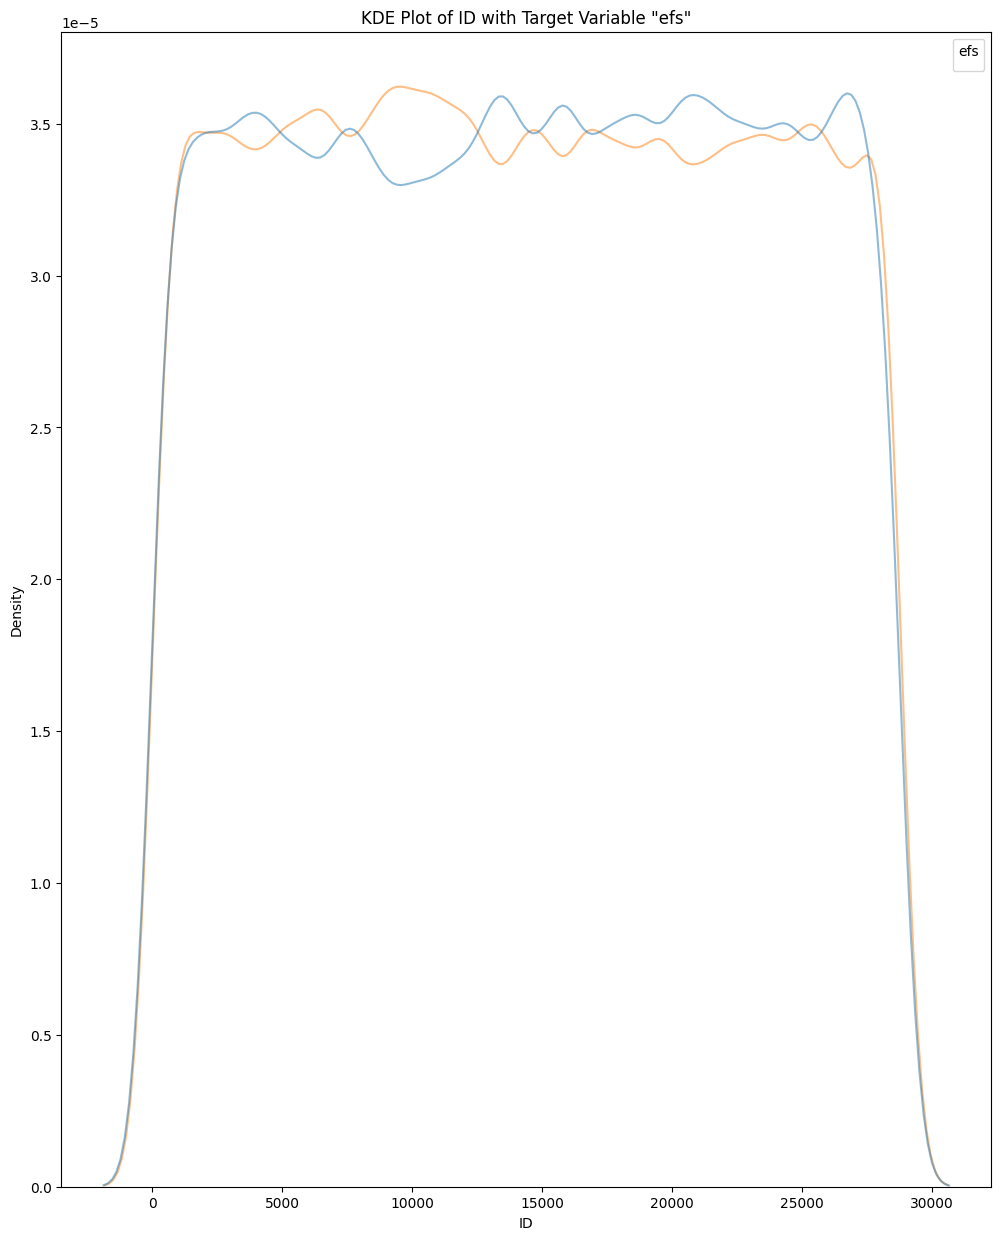

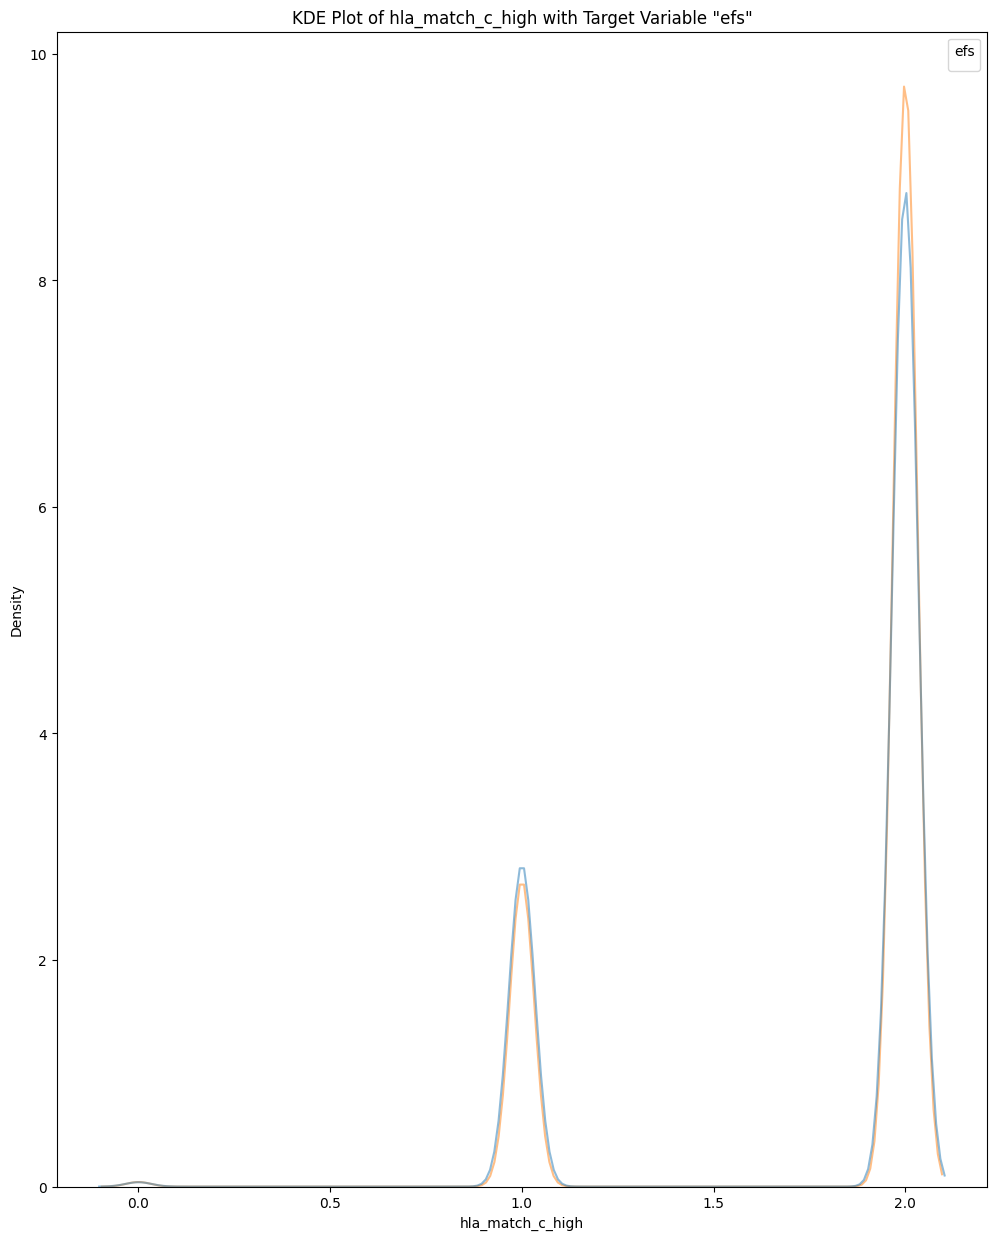

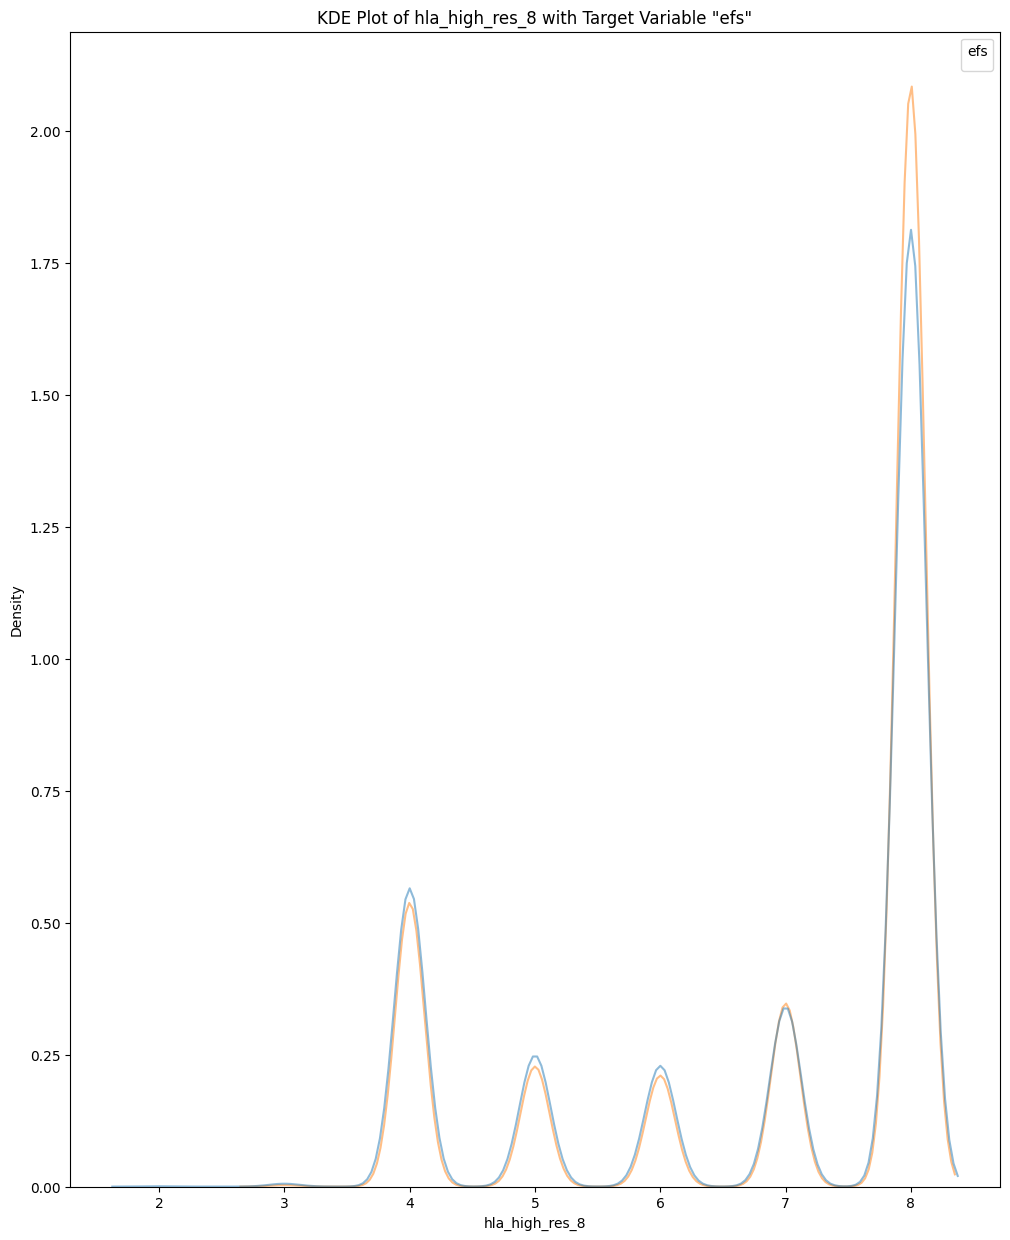

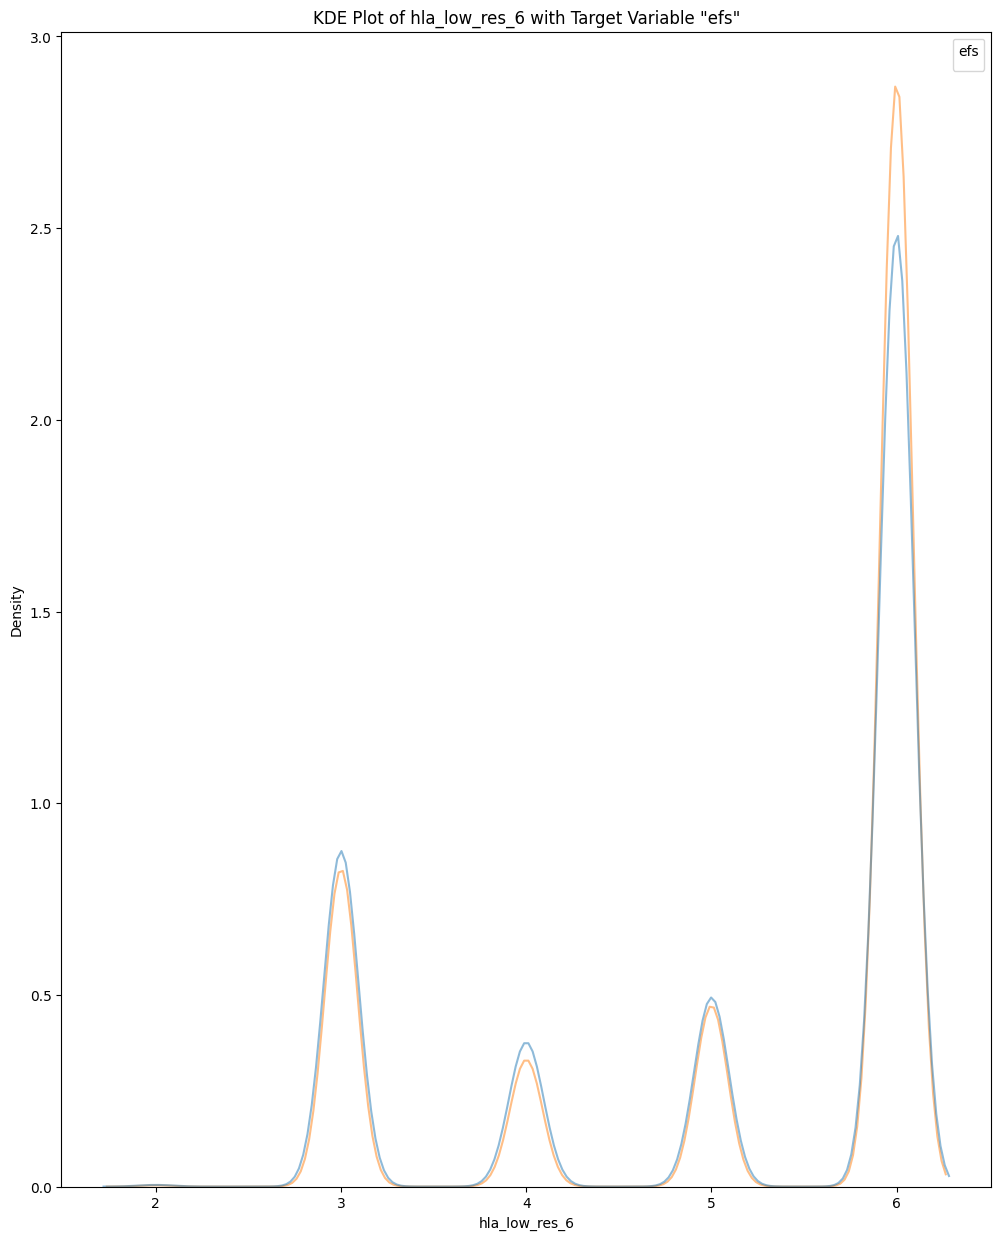

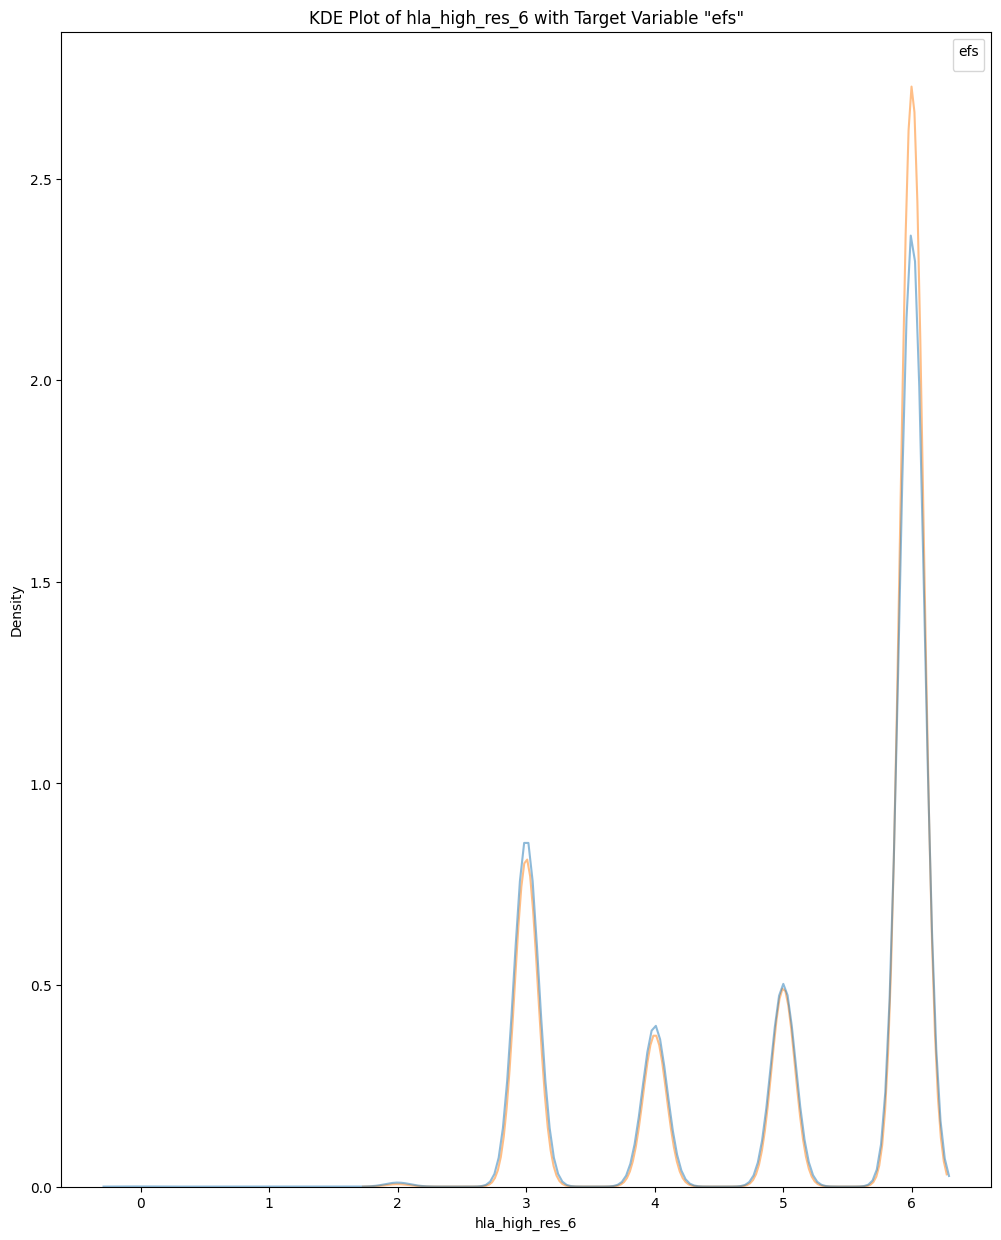

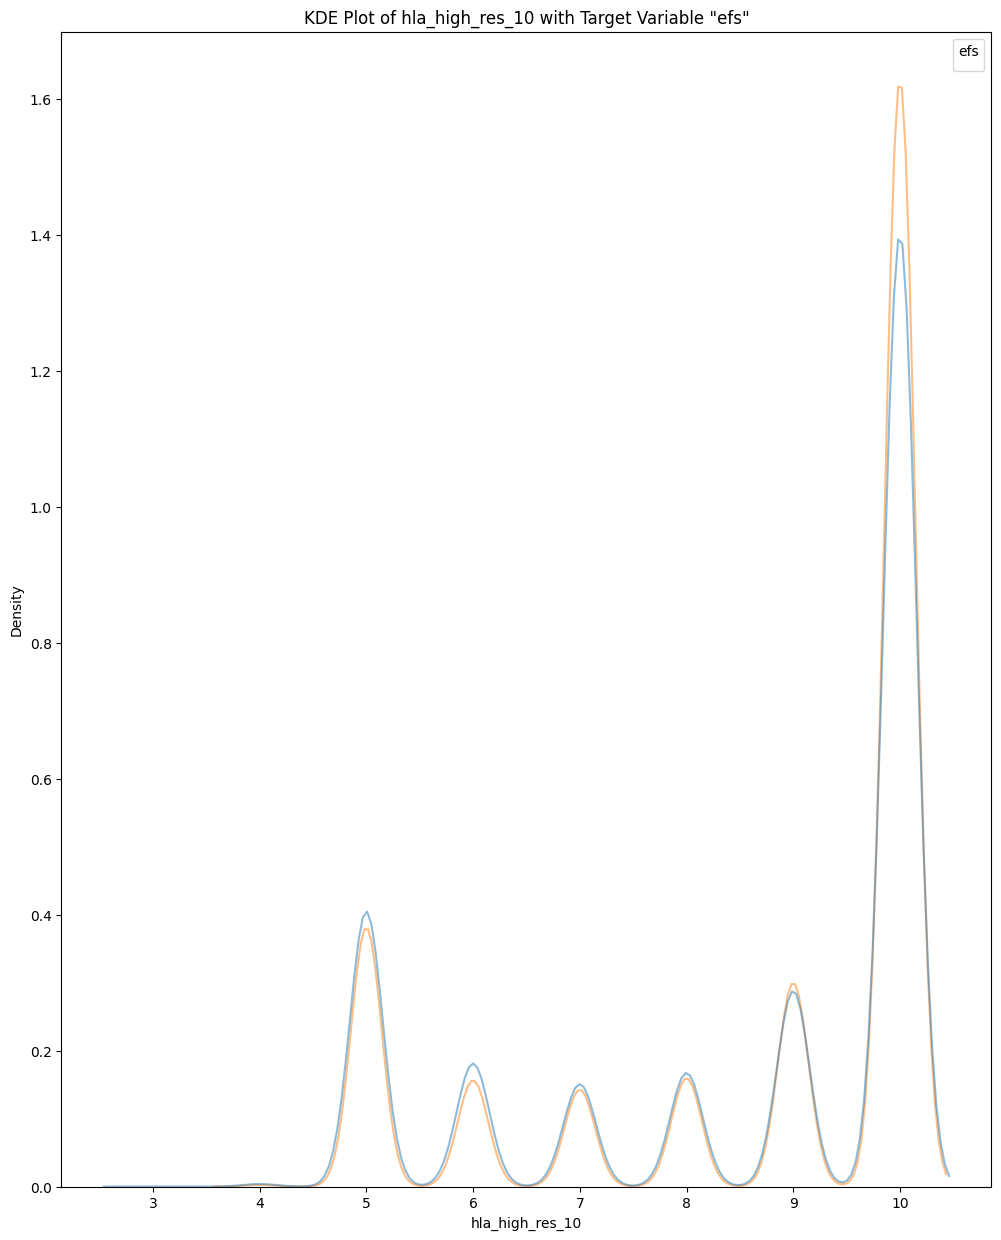

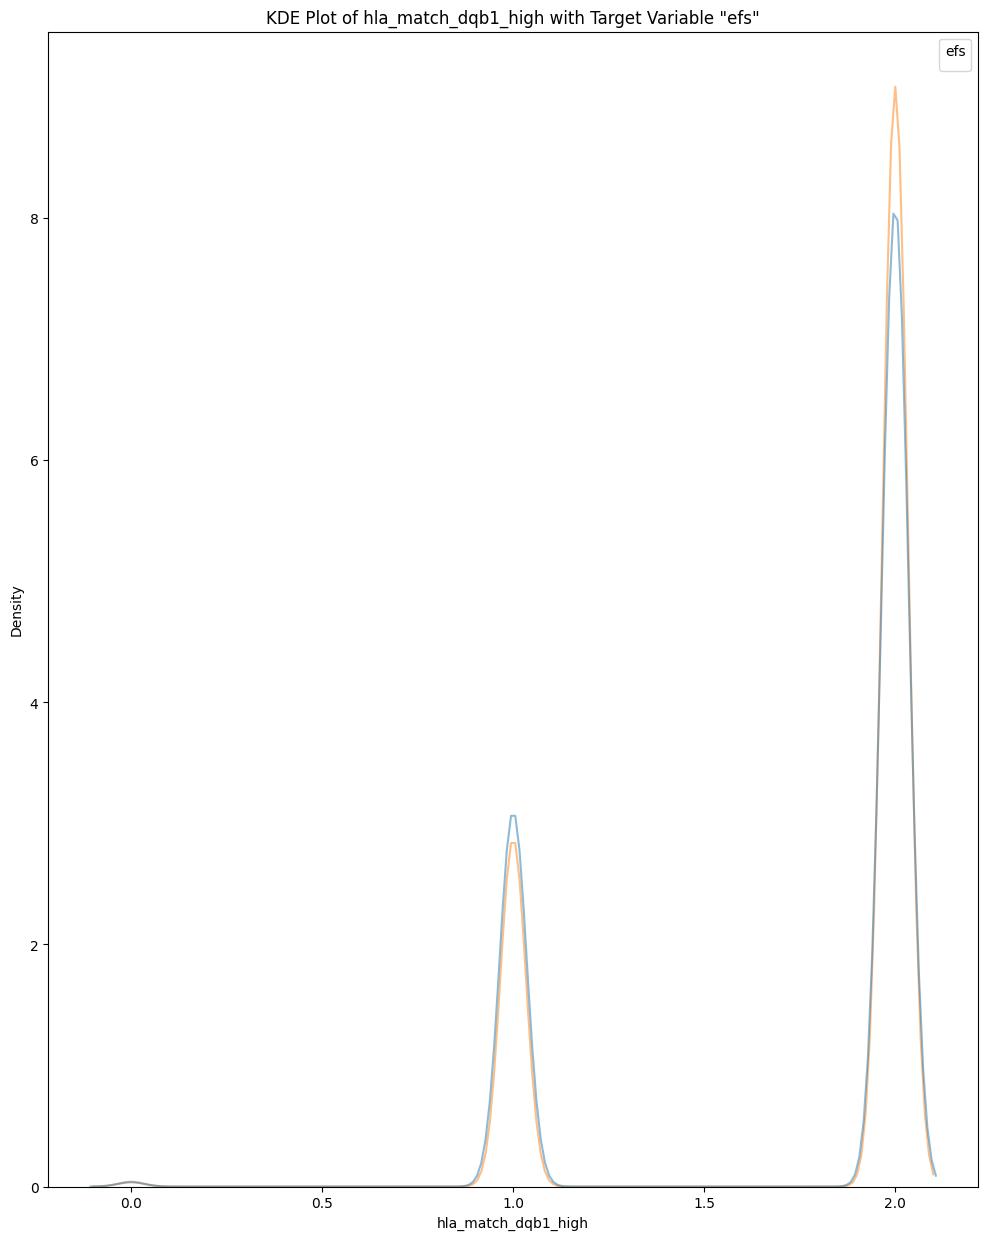

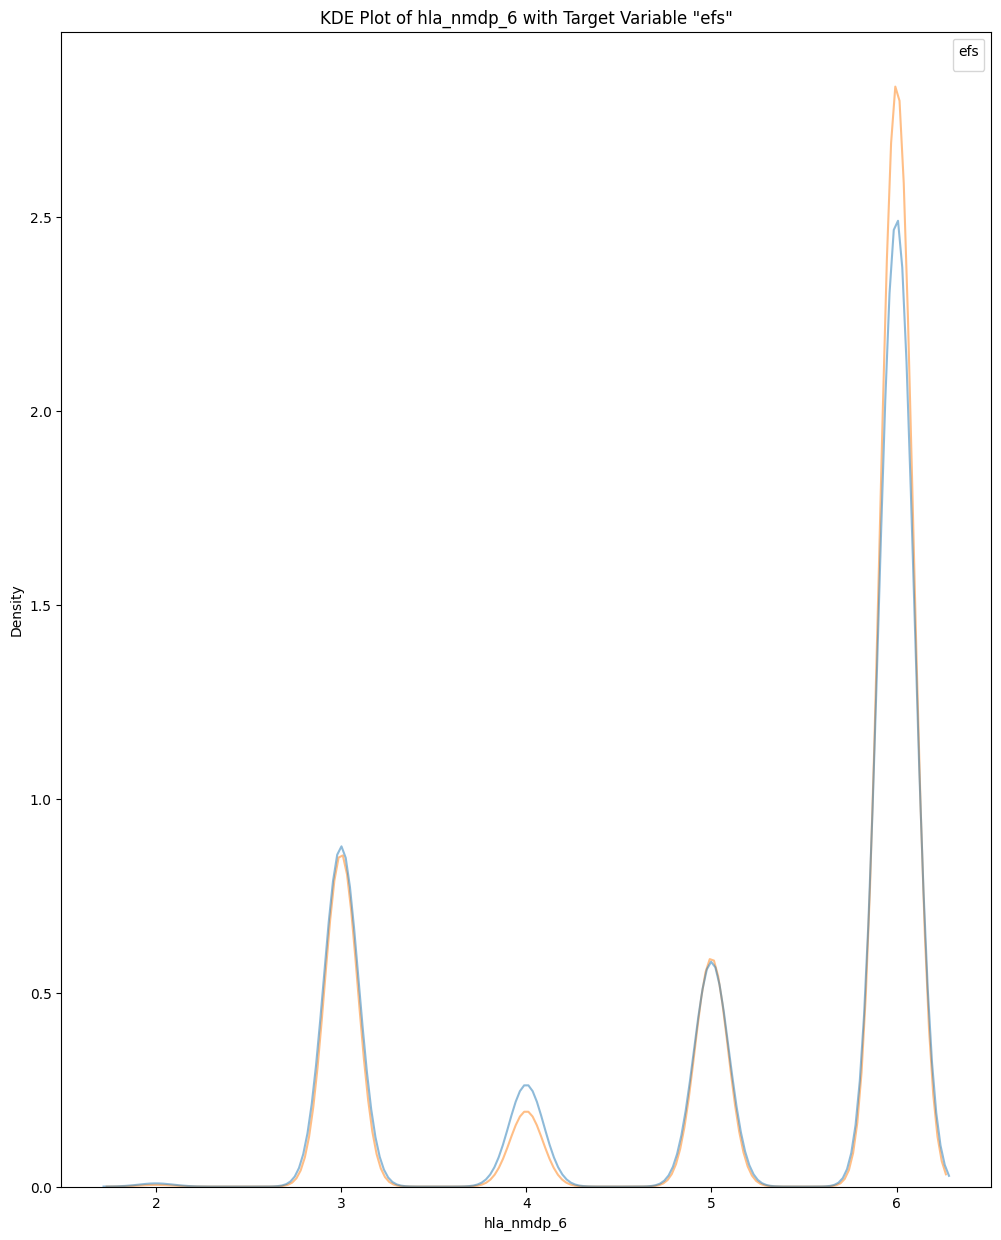

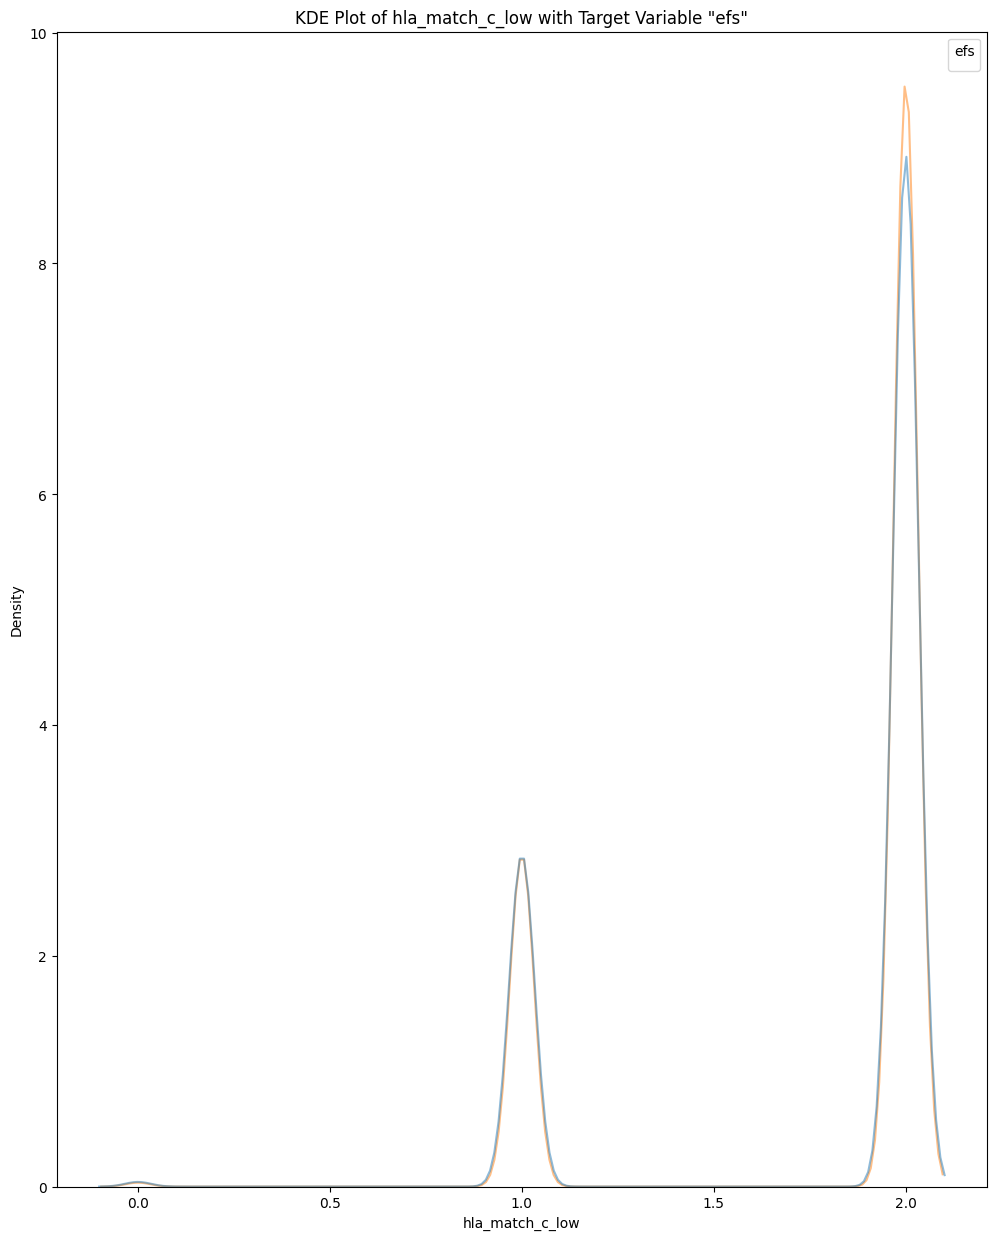

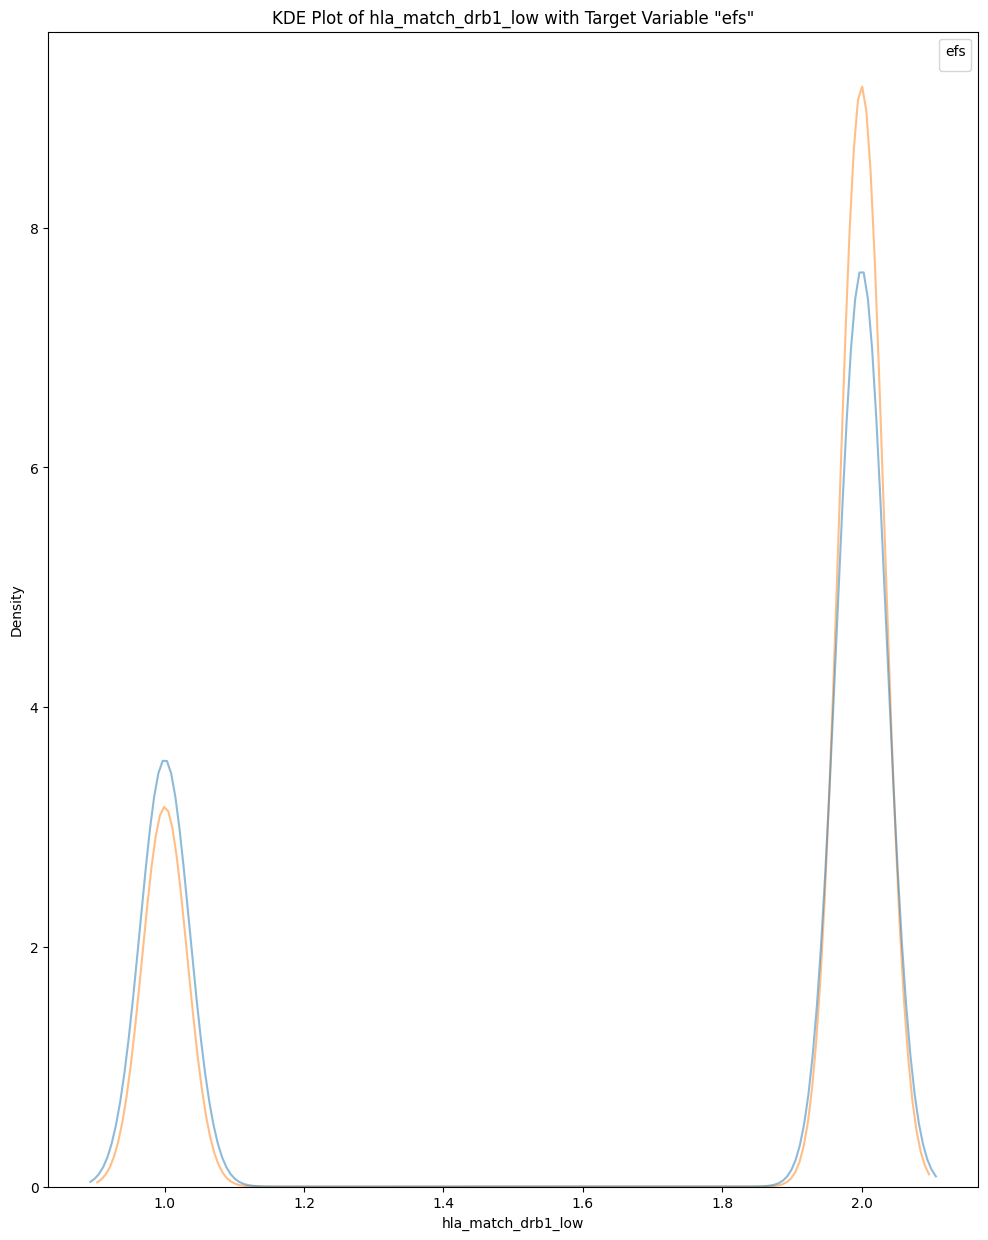

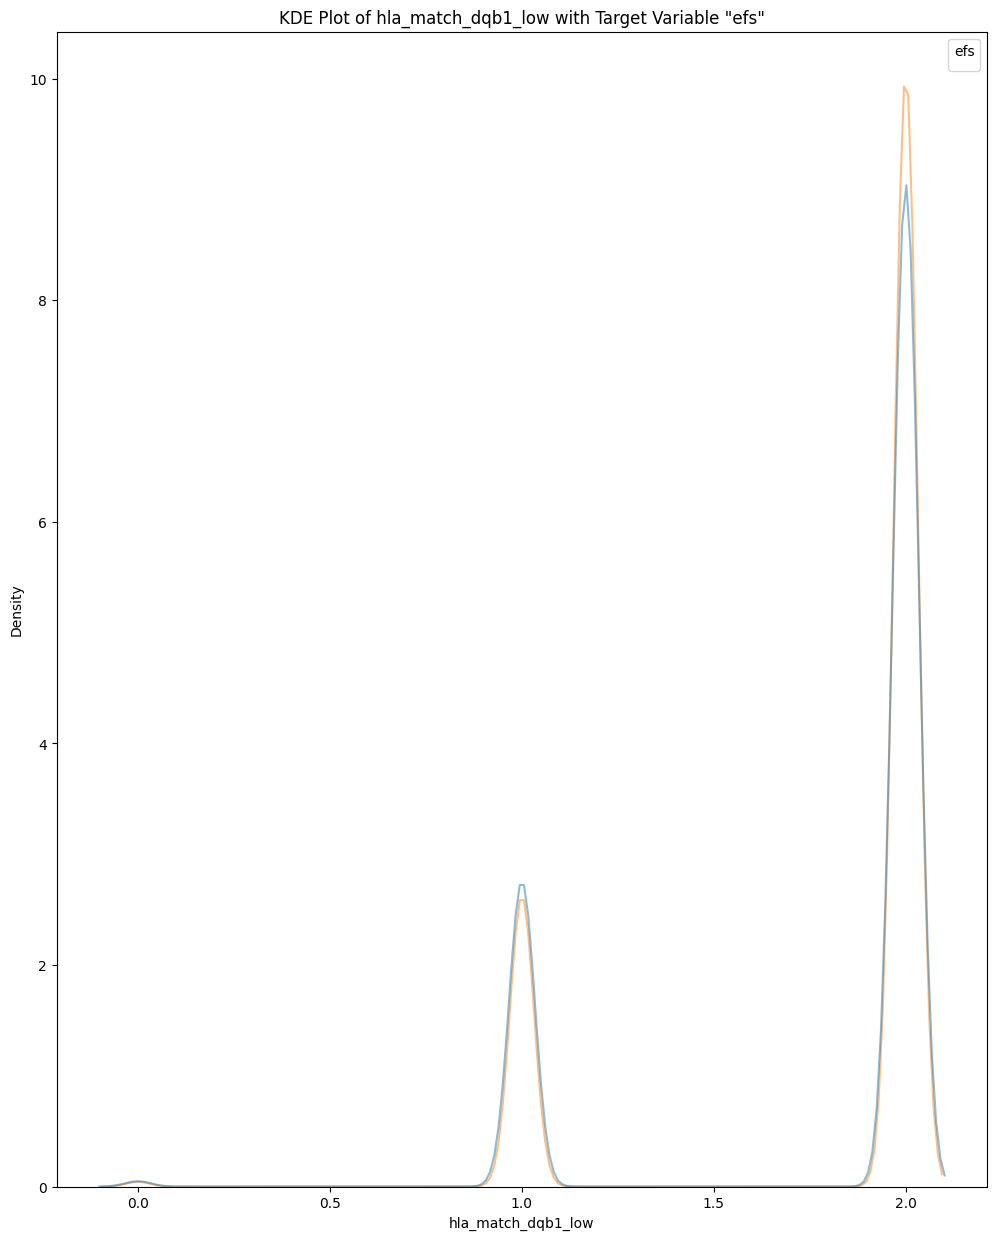

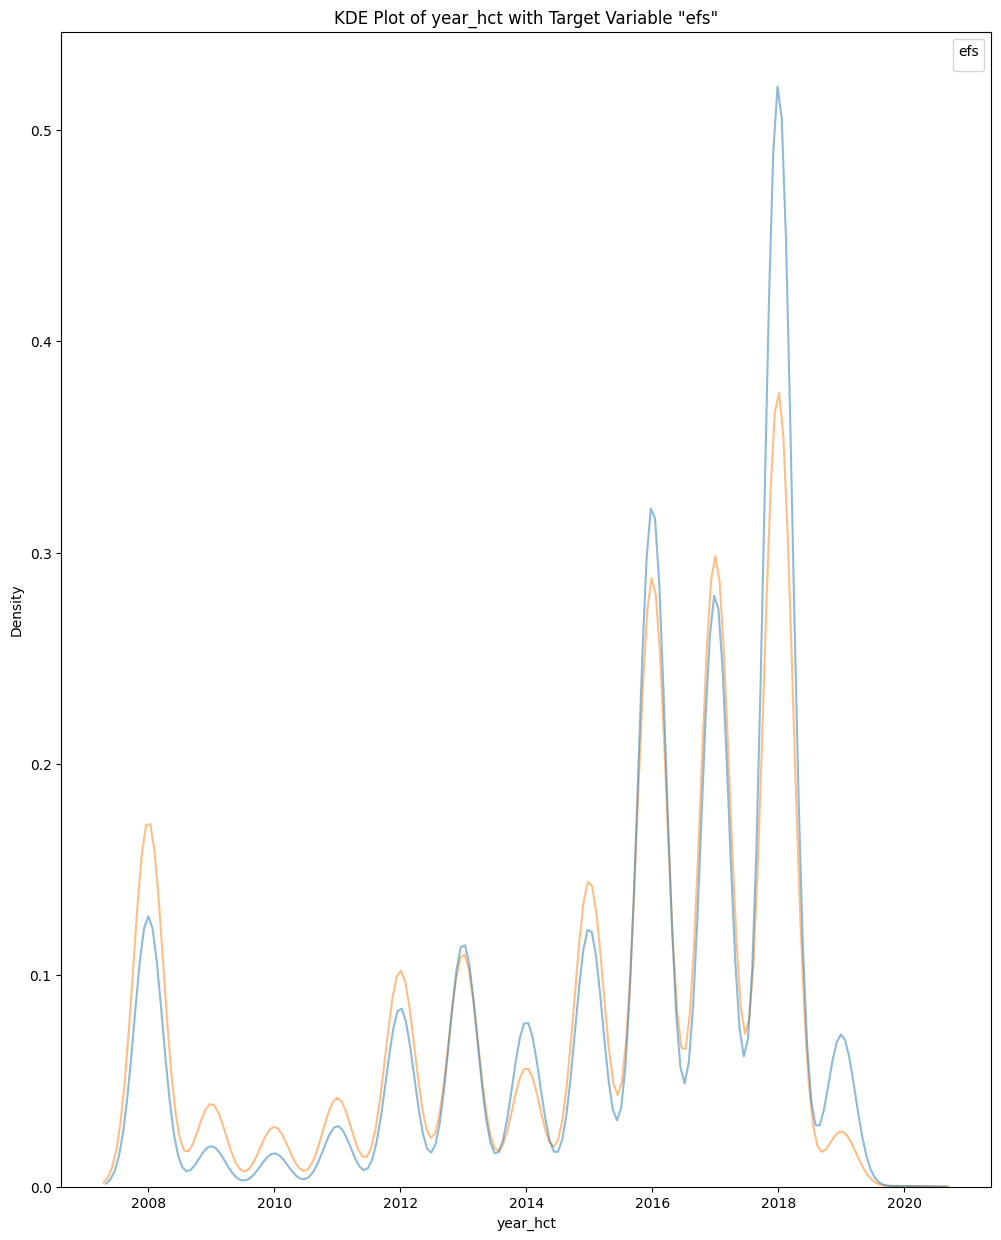

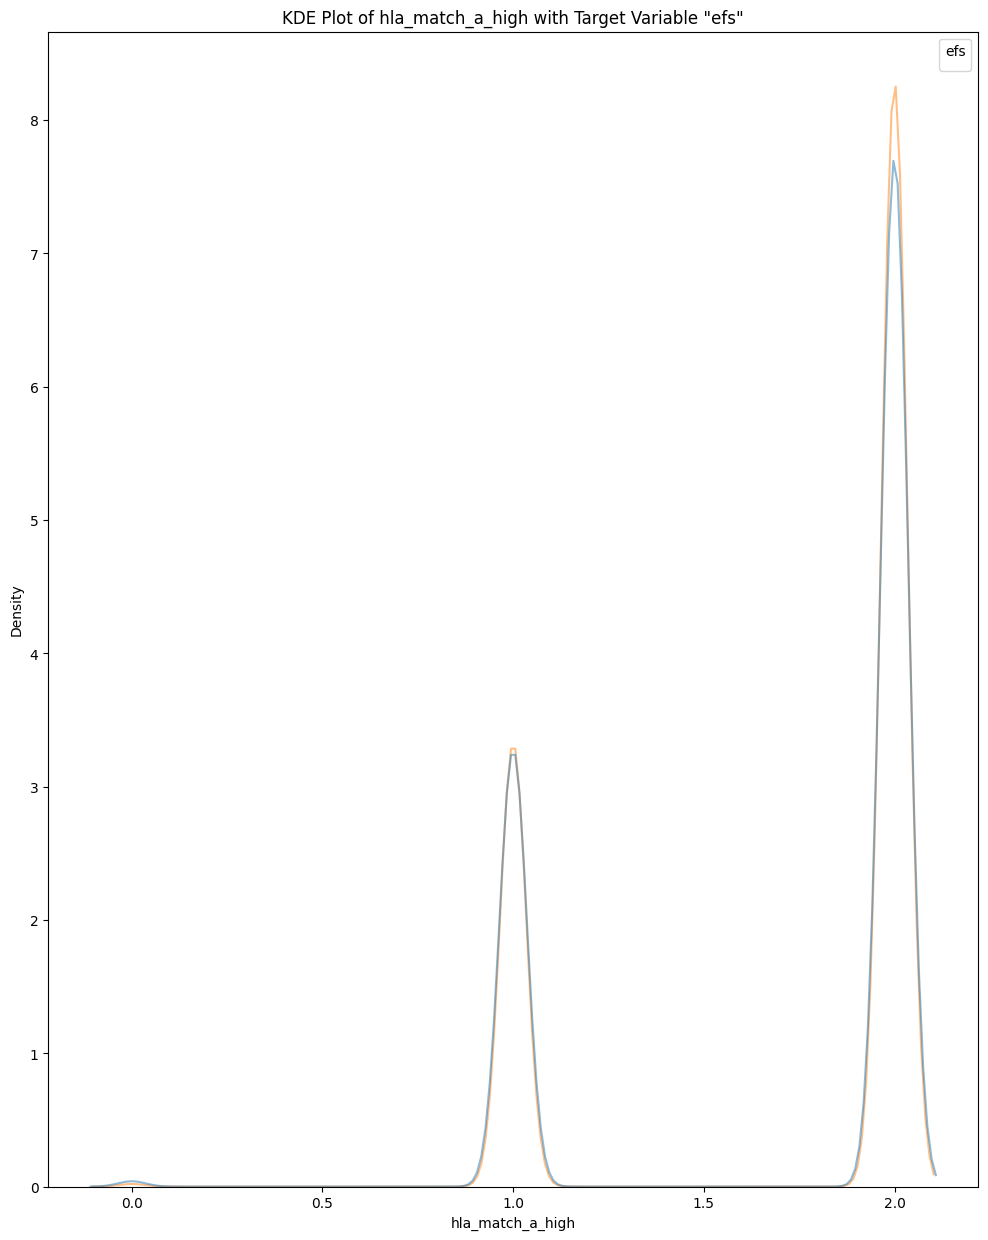

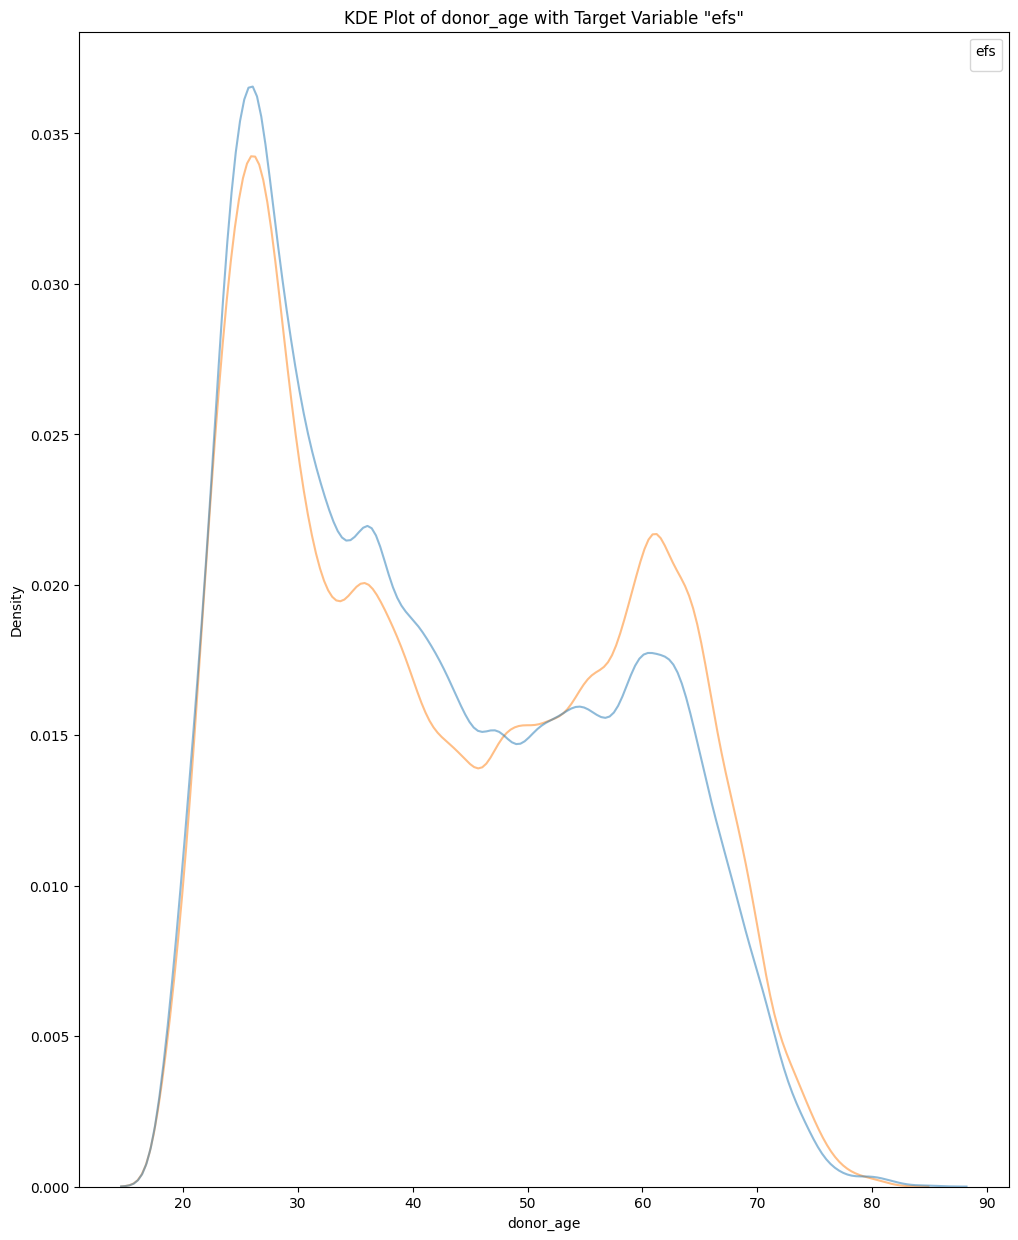

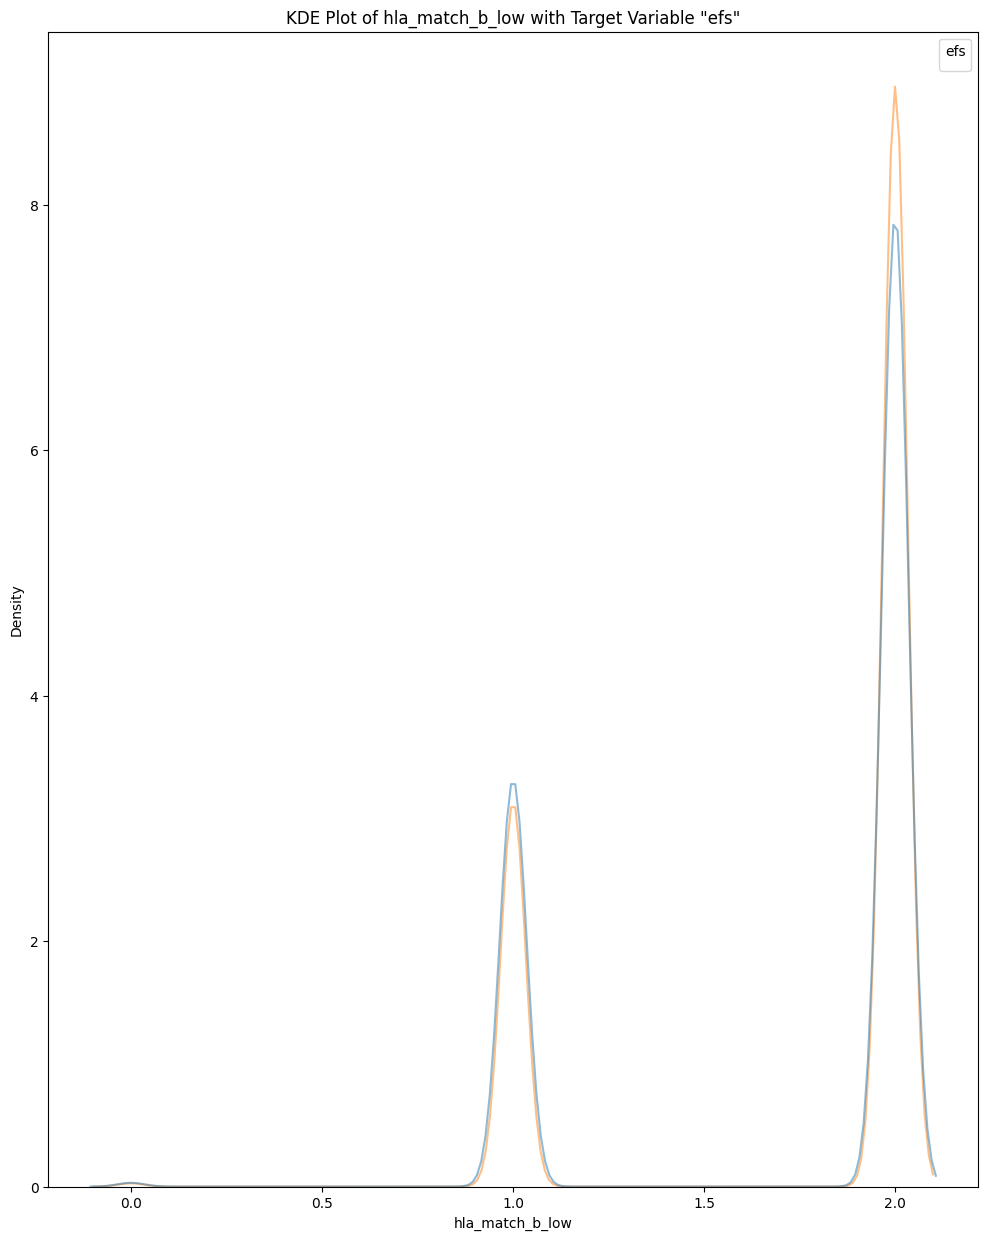

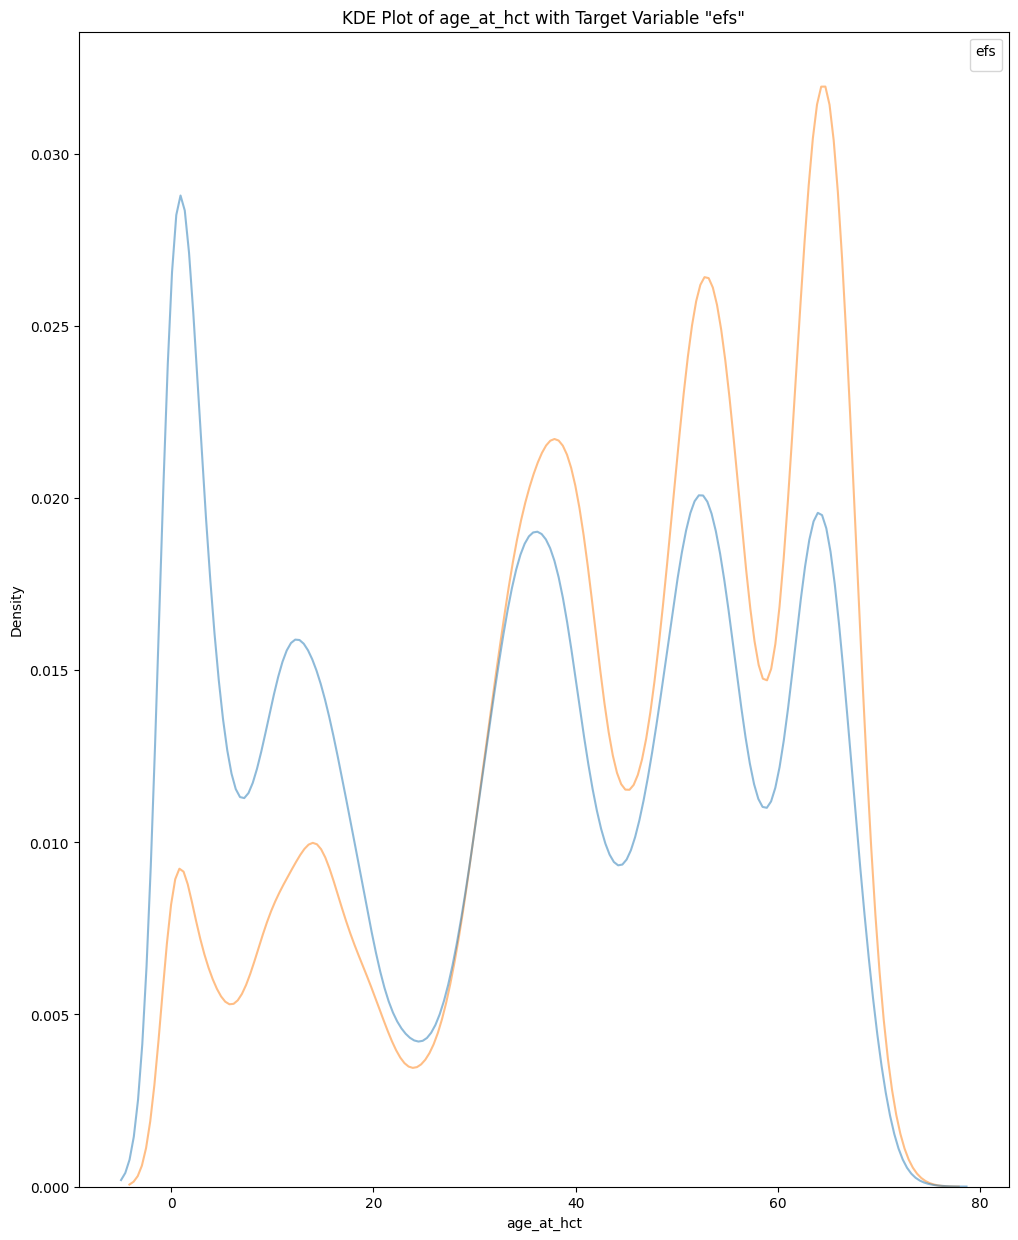

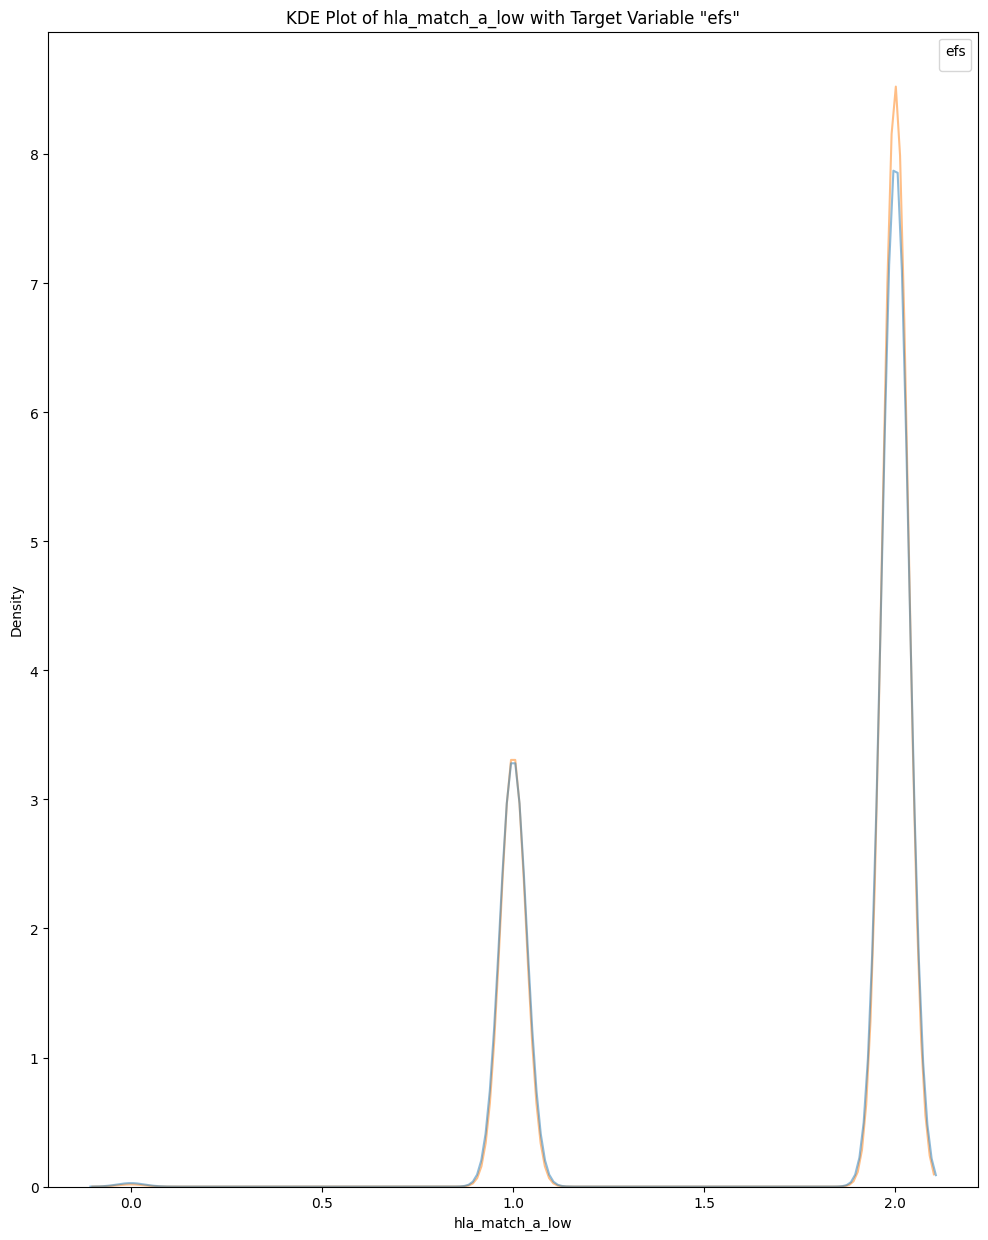

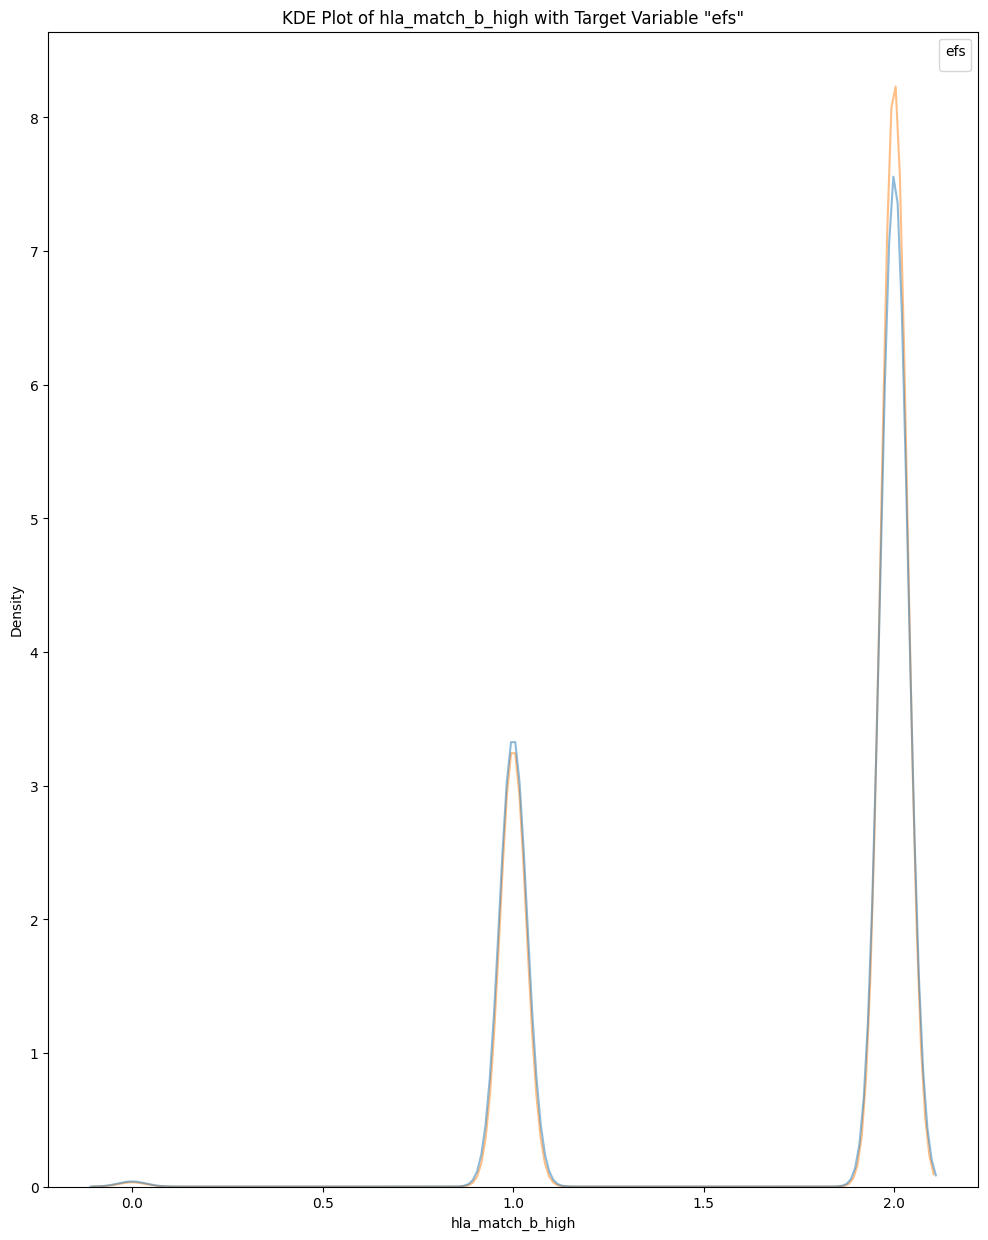

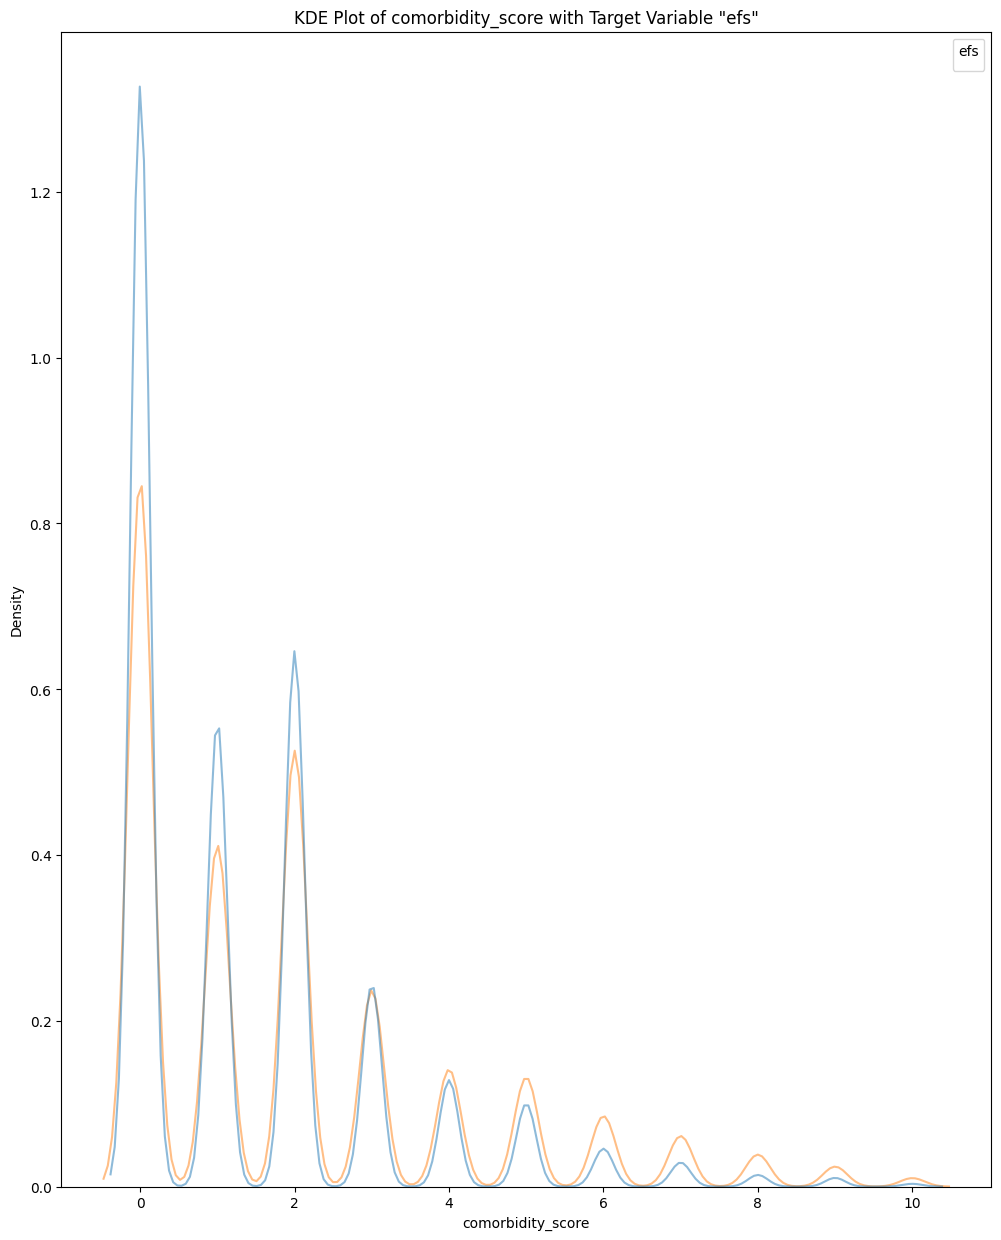

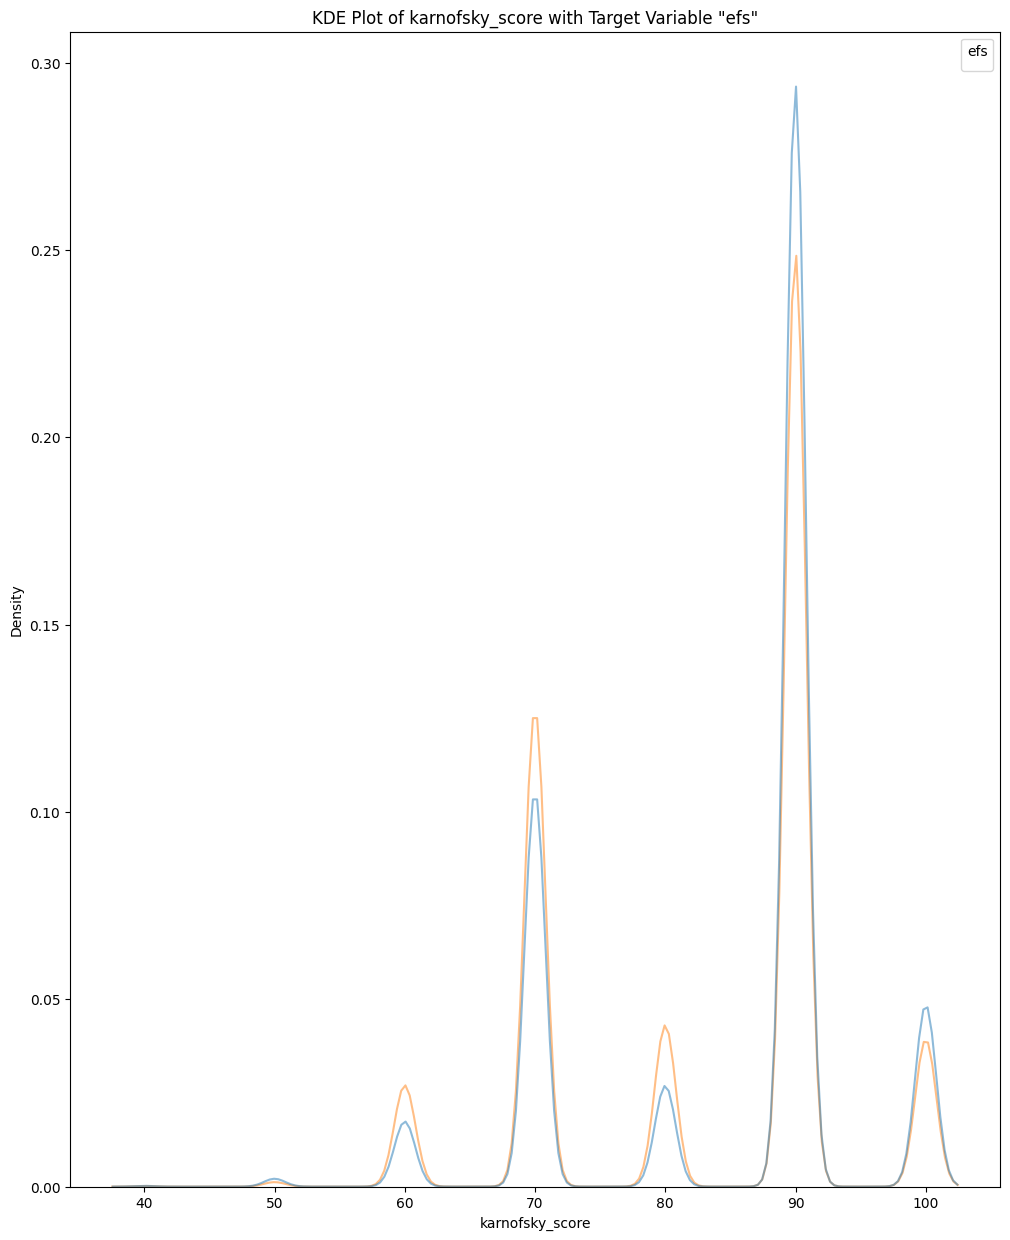

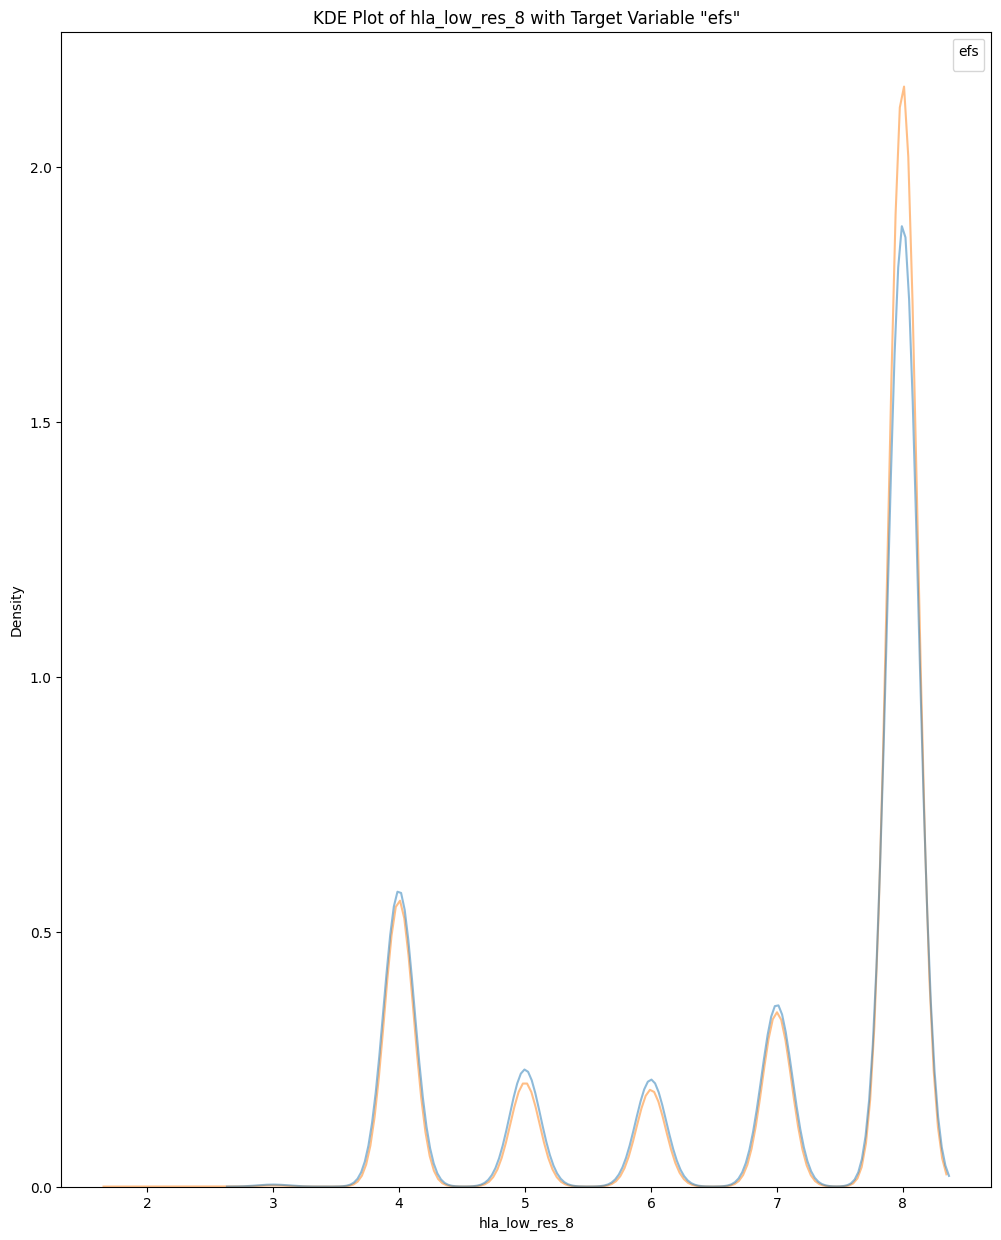

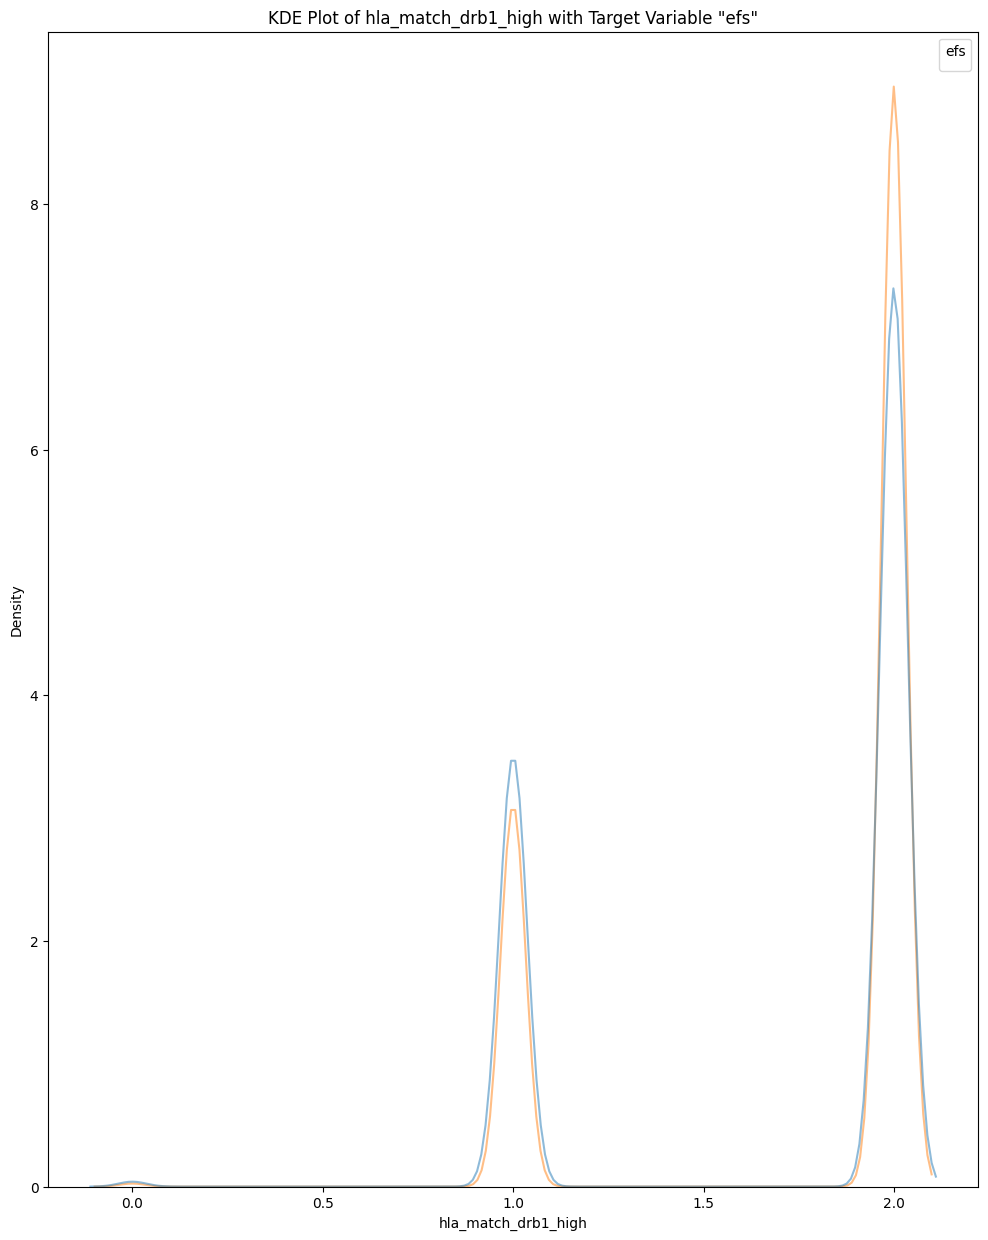

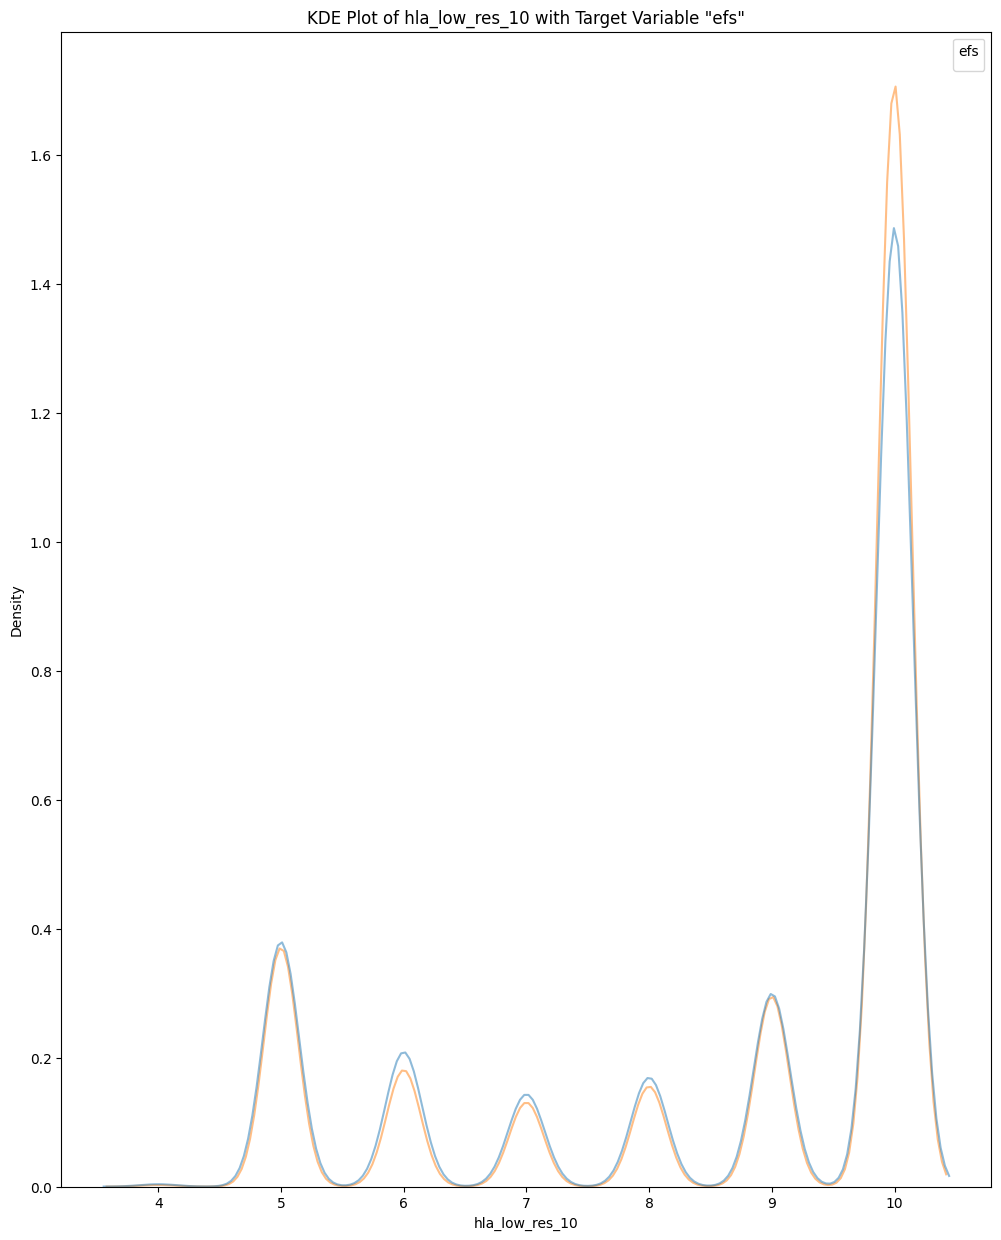

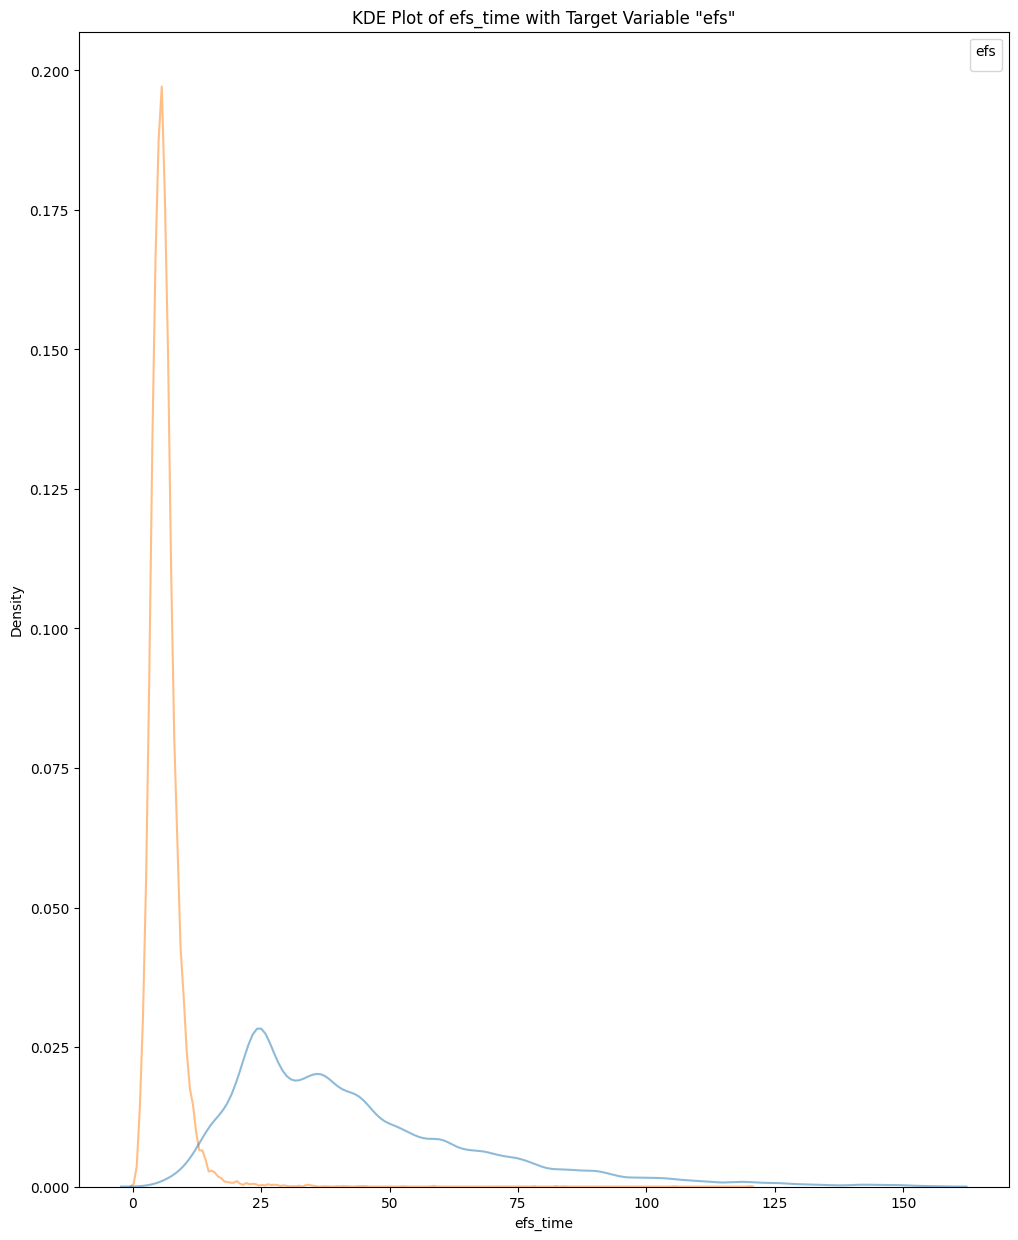

In [17]:
for col in numerical_columns:
    plt.figure(figsize=(12, 15))
    try:
        sns.kdeplot(
            data=train,
            x=col,
            hue='efs',
            common_norm=False,
            fill=False,  # No fill, just the line
            alpha=0.5,
            bw_adjust=0.5  # Adjusts bandwidth for smoother plots
        )
        plt.title(f'KDE Plot of {col} with Target Variable "efs"')
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.legend(title='efs')
        plt.show()
    except Exception as e:
        print(f"Could not plot {col} due to: {e}")

**efs_time** column is very much informative for this data:

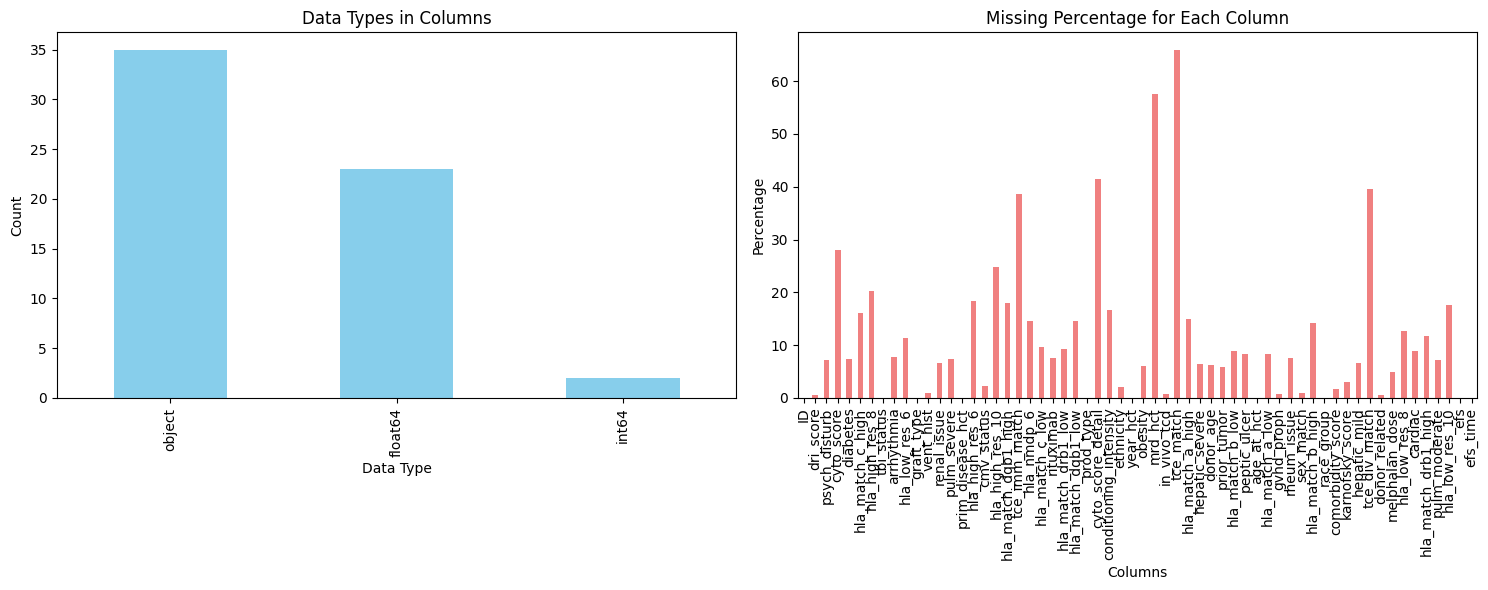

In [18]:
data_types = train.dtypes
missing_percentage = train.isnull().mean() * 100

# Create a DataFrame to combine the results
summary = pd.DataFrame({
    'Data Type': data_types,
    'Missing Percentage': missing_percentage
})

# Plot the data
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot data types
summary['Data Type'].value_counts().plot(kind='bar', ax=ax[0], color='skyblue')
ax[0].set_title('Data Types in Columns')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Data Type')

# Plot missing value percentages
summary['Missing Percentage'].plot(kind='bar', ax=ax[1], color='lightcoral')
ax[1].set_title('Missing Percentage for Each Column')
ax[1].set_ylabel('Percentage')
ax[1].set_xlabel('Columns')

# Rotate x-axis labels for better readability
for axis in ax:
    axis.set_xticklabels(axis.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

# Dropping the Un-necessary Columns:

In [19]:
train.columns

Index(['ID', 'dri_score', 'psych_disturb', 'cyto_score', 'diabetes',
       'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia',
       'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue',
       'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status',
       'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6',
       'hla_match_c_low', 'rituximab', 'hla_match_drb1_low',
       'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail',
       'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct',
       'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe',
       'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer',
       'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue',
       'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score',
       'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related',
       'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_hi

In [20]:
train['tce_imm_match'].unique()

array([nan, 'P/P', 'G/B', 'H/B', 'G/G', 'P/H', 'P/B', 'H/H', 'P/G'],
      dtype=object)

In [21]:
train['cyto_score_detail'].unique()

array([nan, 'Intermediate', 'TBD', 'Poor', 'Favorable', 'Not tested'],
      dtype=object)

In [22]:
train['mrd_hct'].unique()

array([nan, 'Positive', 'Negative'], dtype=object)

In [23]:
train['tce_match'].unique()

array([nan, 'Permissive', 'HvG non-permissive', 'Fully matched',
       'GvH non-permissive'], dtype=object)

In [24]:
train['cyto_score'].unique()

array([nan, 'Intermediate', 'Poor', 'Other', 'Favorable', 'TBD', 'Normal',
       'Not tested'], dtype=object)

In [25]:
train['tce_div_match'].unique()

array([nan, 'Permissive mismatched', 'GvH non-permissive',
       'HvG non-permissive', 'Bi-directional non-permissive'],
      dtype=object)

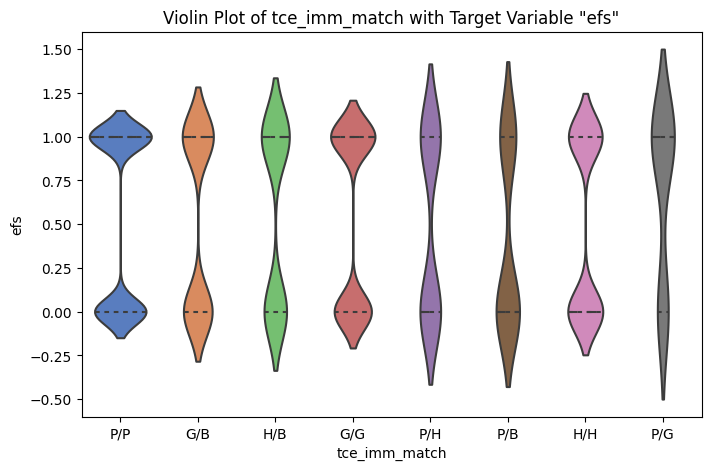

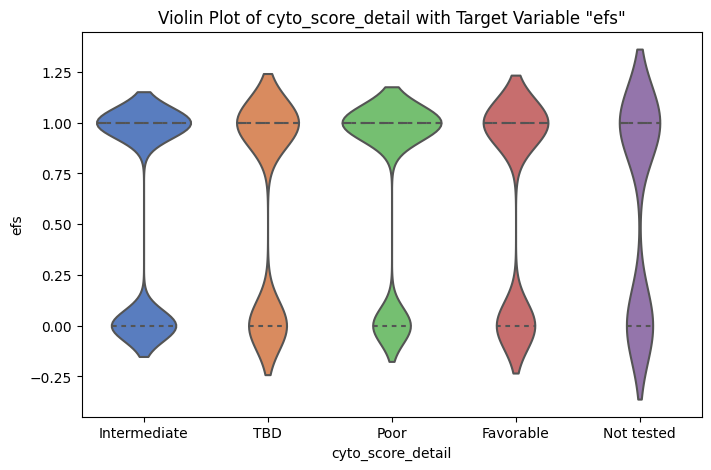

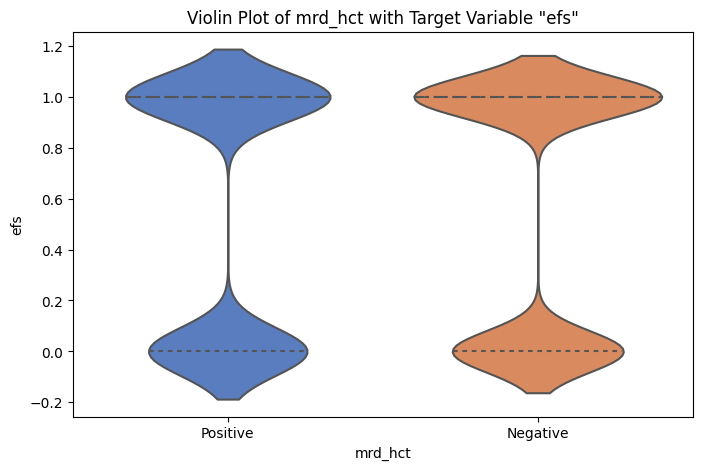

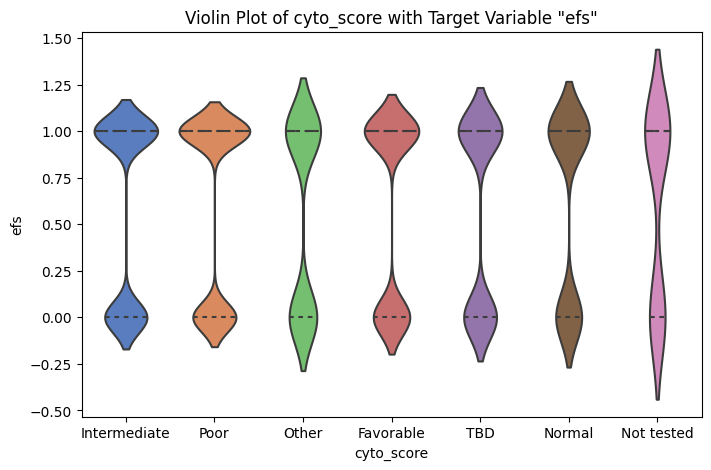

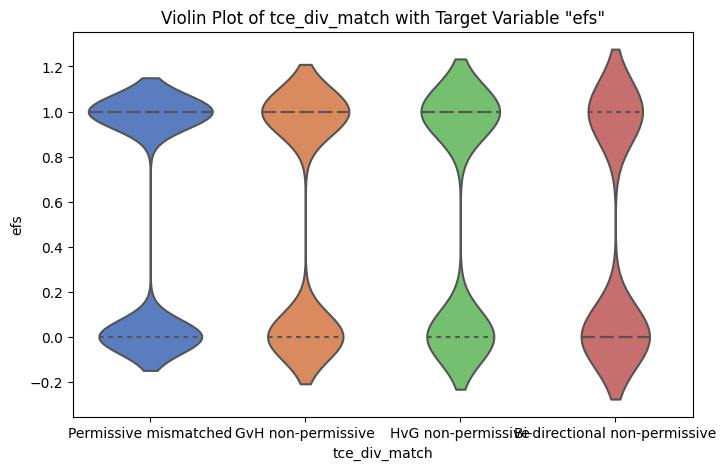

In [26]:
cat_columns = ['tce_imm_match', 'cyto_score_detail', 'mrd_hct','cyto_score','tce_div_match']

for col in cat_columns:
    plt.figure(figsize=(8, 5))
    try:
        sns.violinplot(x=col, y='efs', data=train, inner='quart', palette='muted')
        plt.title(f'Violin Plot of {col} with Target Variable "efs"')
        plt.xlabel(col)
        plt.ylabel('efs')
        plt.show()
    except Exception as e:
        print(f"Could not plot {col} due to: {e}")

In [27]:
# Missing Values Relationship with the target var.


<Figure size 1200x800 with 0 Axes>

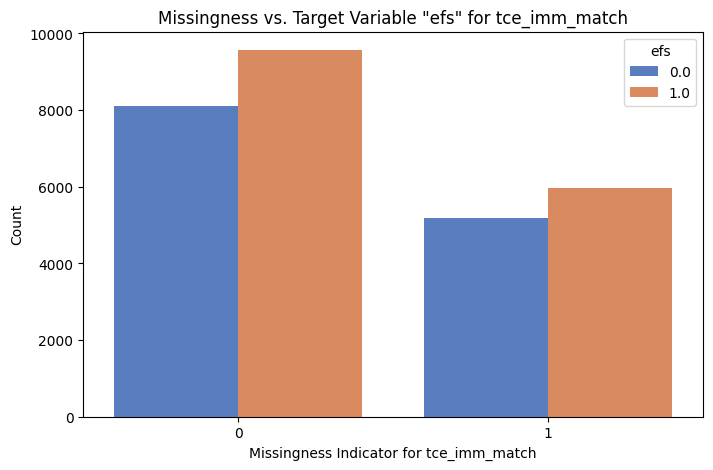

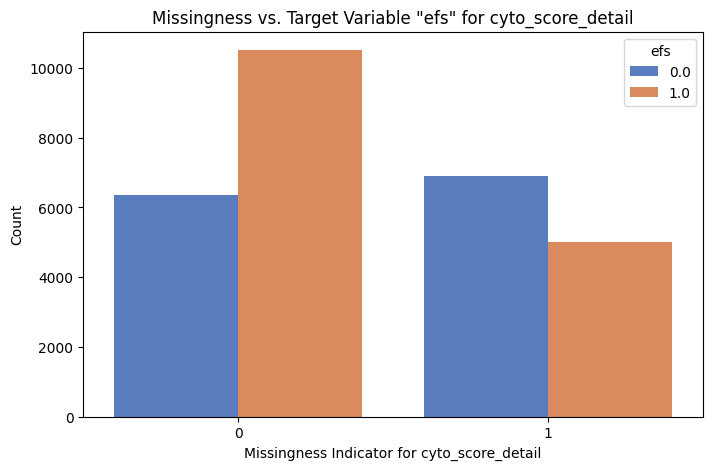

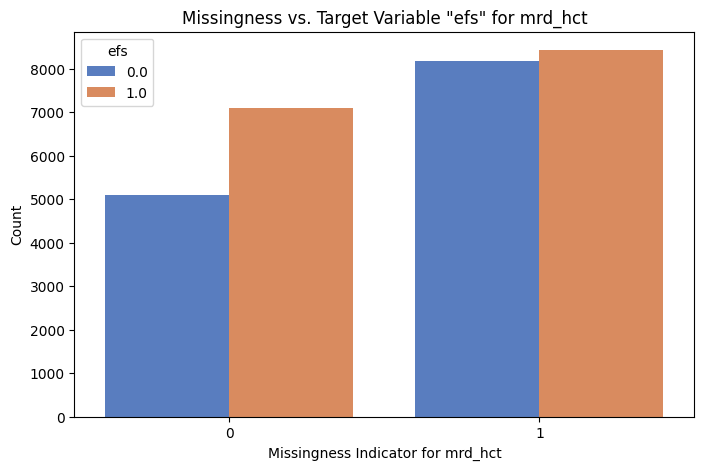

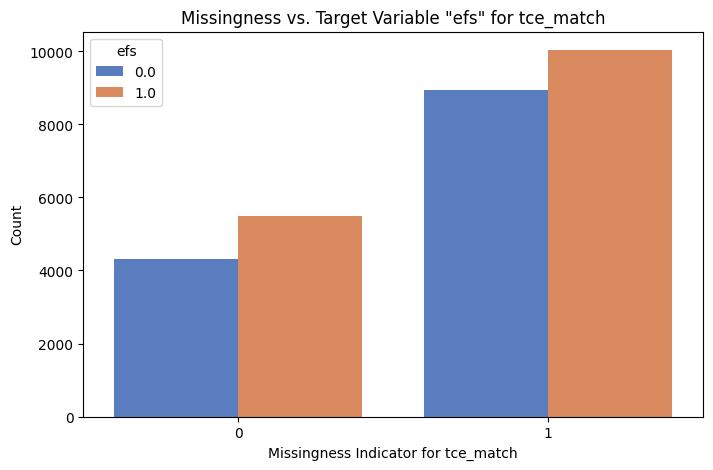

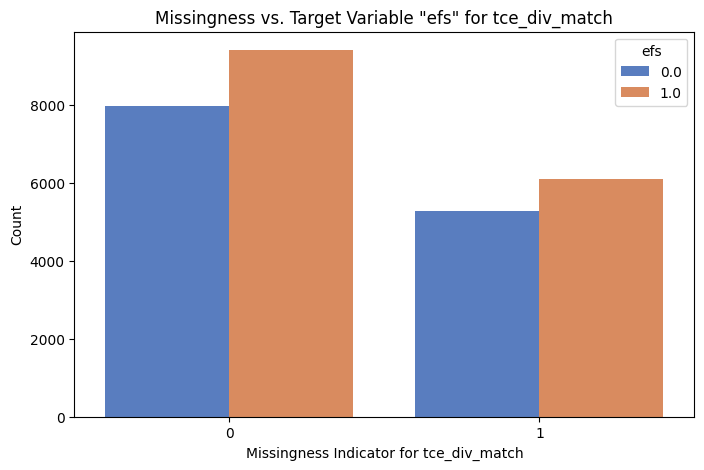

In [28]:
columns_with_missing = train.columns[train.isnull().mean() > 0.30]

missing_indicators = train[columns_with_missing].isnull().astype(int)


missing_indicators['efs'] = train['efs']

# Plot the relationship between missingness and 'efs'
plt.figure(figsize=(12, 8))
for col in missing_indicators.columns[:-1]:  # Exclude 'efs' column
    plt.figure(figsize=(8, 5))
    sns.countplot(data=missing_indicators, x=col, hue='efs', palette='muted')
    plt.title(f'Missingness vs. Target Variable "efs" for {col}')
    plt.xlabel(f'Missingness Indicator for {col}')
    plt.ylabel('Count')
    plt.legend(title='efs')
    plt.show()

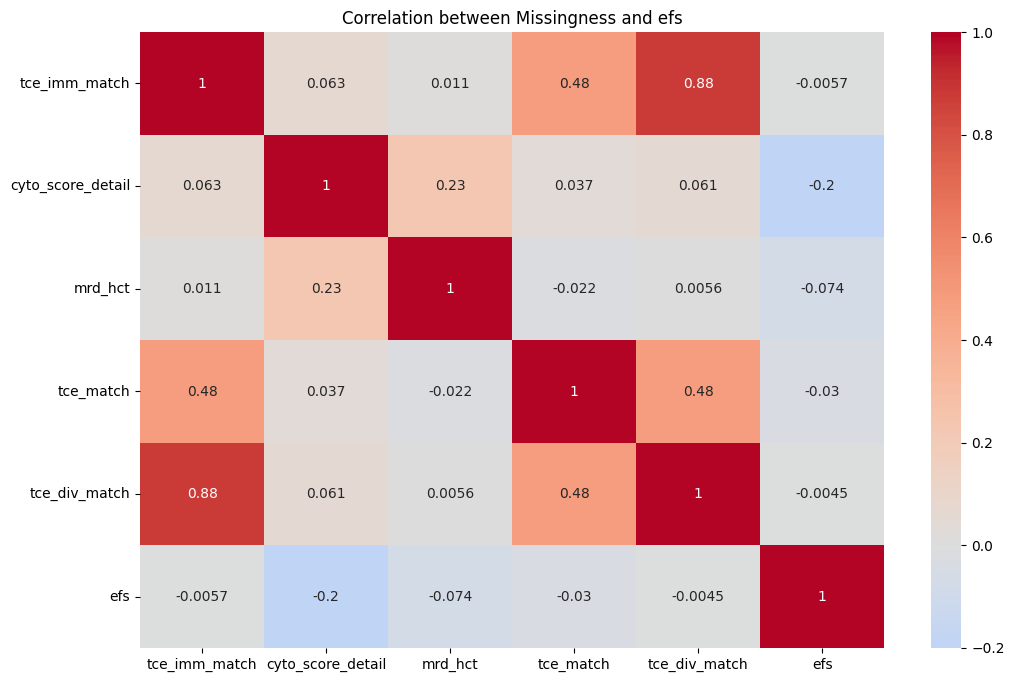

In [29]:
plt.figure(figsize=(12, 8))

# Convert missingness to 1 or 0 for missing and non-missing values
missing_indicators = train[columns_with_missing].isnull().astype(int)

# Add the target variable 'efs' to the missingness indicator DataFrame
missing_indicators['efs'] = train['efs']

# Create a heatmap to visualize the correlation
sns.heatmap(missing_indicators.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Missingness and efs')
plt.show()

**tce_div_match** is important col here , we have to keep it and drop the other unnecessary cols:

In [30]:
train = train.drop(['tce_imm_match', 'cyto_score_detail', 'mrd_hct','cyto_score','ID'],axis=1)

In [31]:
test = test.drop(['tce_imm_match', 'cyto_score_detail', 'mrd_hct','cyto_score','ID'],axis=1)

**<span style="color:green;">Heatmap</span>**

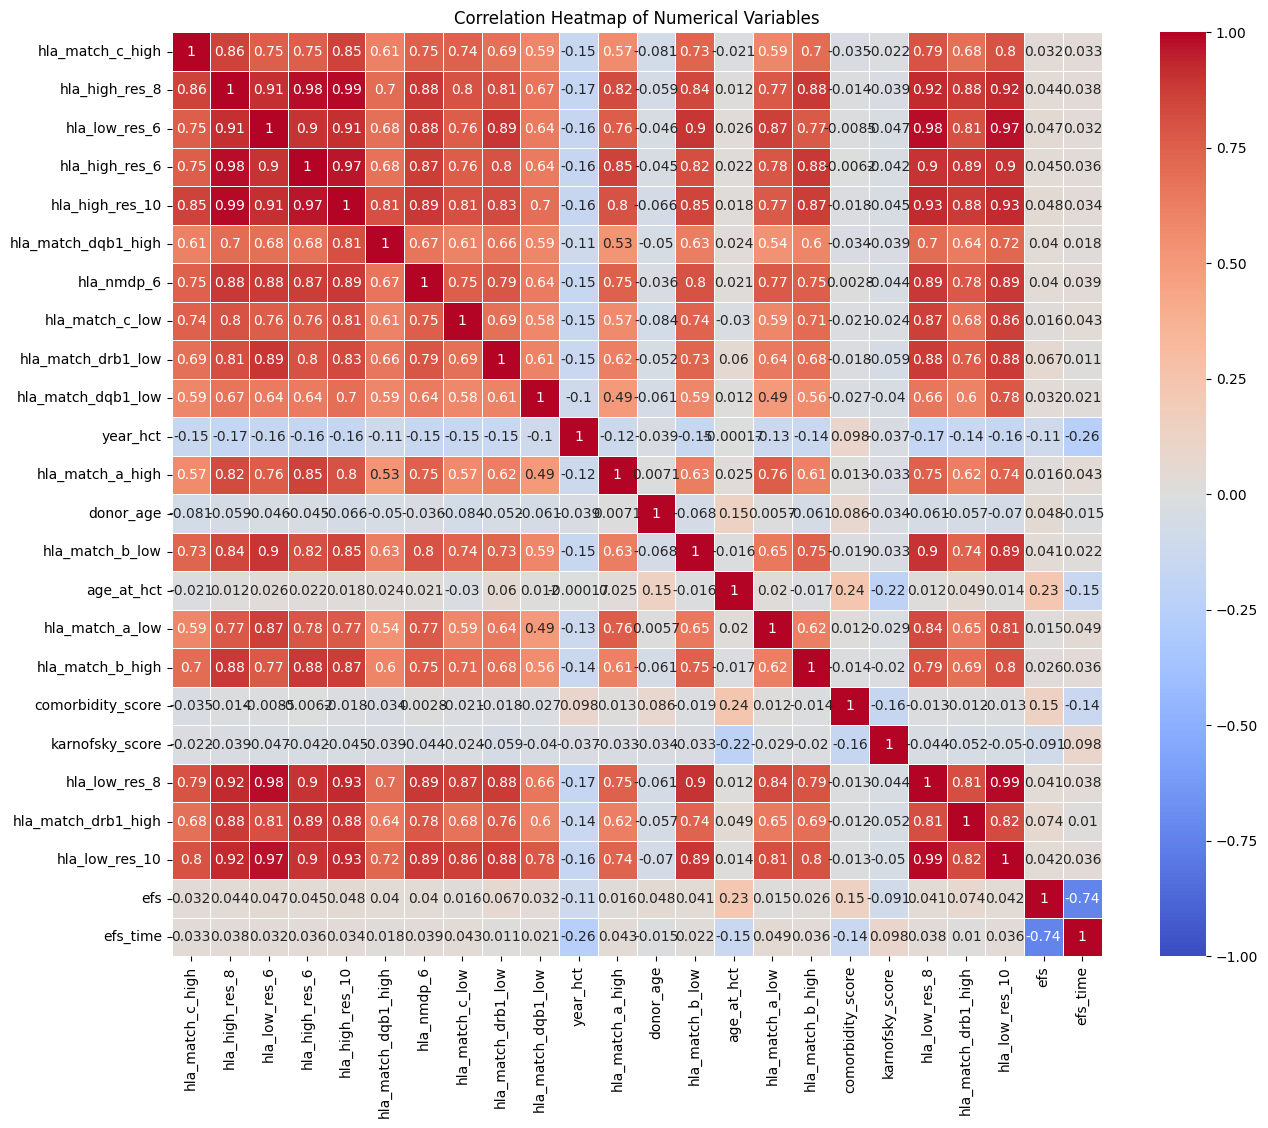

In [32]:
numerical_cols = train.select_dtypes(include=['float64', 'int64']).columns


corr_matrix = train[numerical_cols].corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Variables")
plt.show()


In [33]:
numerical_cols

Index(['hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6',
       'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6',
       'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low',
       'year_hct', 'hla_match_a_high', 'donor_age', 'hla_match_b_low',
       'age_at_hct', 'hla_match_a_low', 'hla_match_b_high',
       'comorbidity_score', 'karnofsky_score', 'hla_low_res_8',
       'hla_match_drb1_high', 'hla_low_res_10', 'efs', 'efs_time'],
      dtype='object')

In [34]:
highly_corr_cols = ['hla_high_res_8','hla_low_res_6','hla_high_res_6','hla_high_res_10',
                    'hla_nmdp_6','hla_match_c_low','hla_match_b_low',
                    'hla_match_b_high','hla_low_res_8','hla_low_res_10','hla_match_dqb1_low','hla_match_drb1_low']

In [35]:
train.drop(highly_corr_cols,inplace = True , axis =1 )
test.drop(highly_corr_cols,inplace = True , axis =1 )

# Imputation of NANs

**Columns wihth Less than 8% of missing Values**

In [36]:
train.columns

Index(['dri_score', 'psych_disturb', 'diabetes', 'hla_match_c_high',
       'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue',
       'pulm_severe', 'prim_disease_hct', 'cmv_status', 'hla_match_dqb1_high',
       'rituximab', 'prod_type', 'conditioning_intensity', 'ethnicity',
       'year_hct', 'obesity', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high',
       'hepatic_severe', 'donor_age', 'prior_tumor', 'peptic_ulcer',
       'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue',
       'sex_match', 'race_group', 'comorbidity_score', 'karnofsky_score',
       'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose',
       'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'efs', 'efs_time'],
      dtype='object')

In [37]:
train_cols_8 = ['psych_disturb', 'diabetes','arrhythmia','rituximab','ethnicity',
               'obesity', 'in_vivo_tcd','hepatic_severe', 'donor_age', 'prior_tumor', 'peptic_ulcer',
               'hla_match_a_low', 'gvhd_proph', 'rheum_issue','sex_match','comorbidity_score',
                'karnofsky_score','hepatic_mild', 'donor_related', 'melphalan_dose',
                'cardiac', 'hla_match_drb1_high', 'pulm_moderate','dri_score','vent_hist', 'renal_issue',
                'pulm_severe','cmv_status'
               ]

**As the %age of NANs is less , we can impute them through the median values for num cols and mode values for the cat cols**

In [38]:
# Extract numerical and categorical columns
num_cols = train[train_cols_8].select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = train[train_cols_8].select_dtypes(include=['object', 'category']).columns.tolist()

print("Numerical Columns:", num_cols)
print("Categorical Columns:", cat_cols)

Numerical Columns: ['donor_age', 'hla_match_a_low', 'comorbidity_score', 'karnofsky_score', 'hla_match_drb1_high']
Categorical Columns: ['psych_disturb', 'diabetes', 'arrhythmia', 'rituximab', 'ethnicity', 'obesity', 'in_vivo_tcd', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hepatic_mild', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate', 'dri_score', 'vent_hist', 'renal_issue', 'pulm_severe', 'cmv_status']


In [39]:
numerical_imputer = SimpleImputer(strategy='median')
train[num_cols] = numerical_imputer.fit_transform(train[num_cols])


categorical_imputer = SimpleImputer(strategy='most_frequent')
train[cat_cols] = categorical_imputer.fit_transform(train[cat_cols])

Now , we have 6 columns remaining with high percentage of nan counts :

we have to handle them carefully.

In [40]:
null_percentage = train.isnull().mean() * 100
high_null_cols = null_percentage[null_percentage > 10].index.tolist()

# Separate high null columns into numerical and categorical
high_null_num_cols = train[high_null_cols].select_dtypes(include=['int64', 'float64']).columns.tolist()
high_null_cat_cols = train[high_null_cols].select_dtypes(include=['object', 'category']).columns.tolist()

for col in high_null_num_cols:
    if train[col].skew() > 1 or train[col].skew() < -1: 
        strategy = 'median'  # Use median for skewed data
    else:
        strategy = 'mean'  # Use mean for normally distributed data
    
    imputer = SimpleImputer(strategy=strategy)
    train[col] = imputer.fit_transform(train[[col]])

categorical_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
train[high_null_cat_cols] = categorical_imputer.fit_transform(train[high_null_cat_cols])



In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   dri_score               28800 non-null  object 
 1   psych_disturb           28800 non-null  object 
 2   diabetes                28800 non-null  object 
 3   hla_match_c_high        28800 non-null  float64
 4   tbi_status              28800 non-null  object 
 5   arrhythmia              28800 non-null  object 
 6   graft_type              28800 non-null  object 
 7   vent_hist               28800 non-null  object 
 8   renal_issue             28800 non-null  object 
 9   pulm_severe             28800 non-null  object 
 10  prim_disease_hct        28800 non-null  object 
 11  cmv_status              28800 non-null  object 
 12  hla_match_dqb1_high     28800 non-null  float64
 13  rituximab               28800 non-null  object 
 14  prod_type               28800 non-null

*Most of the Variables are Categorical*

In [42]:
# Column Diff.
set(train.columns) - set(test.columns)

{'efs', 'efs_time'}

In [43]:
test['efs_time'] = train['efs_time'].mean

In [44]:
X = train.drop("efs",axis=1)
y = train['efs']

# Encoding

In [45]:
cat_cols = X.select_dtypes(include=['object']).columns

In [46]:
# Create a copy of the dataset to avoid modifying the original
encoded_dataset = X.copy()

# Initialize the label encoder
label_encoder = LabelEncoder()

# Iterate over each column in cat_cols and apply label encoding
for col in cat_cols:
    if col in encoded_dataset.columns:
        encoded_dataset[col] = label_encoder.fit_transform(encoded_dataset[col])
    else:
        print(f"Column {col} is missing in the dataset and will be skipped.")

# Display the transformed dataset
print(encoded_dataset.head())


   dri_score  psych_disturb  diabetes  hla_match_c_high  tbi_status  \
0          7              0         0               2.0           0   
1          2              0         0               2.0           6   
2          7              0         0               2.0           0   
3          0              0         0               2.0           0   
4          0              0         0               2.0           0   

   arrhythmia  graft_type  vent_hist  renal_issue  pulm_severe  ...  \
0           0           0          0            0            0  ...   
1           0           1          0            0            0  ...   
2           0           0          0            0            0  ...   
3           0           0          0            0            0  ...   
4           0           1          0            0            0  ...   

   comorbidity_score  karnofsky_score  hepatic_mild  tce_div_match  \
0                0.0             90.0             0              4   
1     

In [47]:
print(encoded_dataset[cat_cols].dtypes)


dri_score                 int64
psych_disturb             int64
diabetes                  int64
tbi_status                int64
arrhythmia                int64
graft_type                int64
vent_hist                 int64
renal_issue               int64
pulm_severe               int64
prim_disease_hct          int64
cmv_status                int64
rituximab                 int64
prod_type                 int64
conditioning_intensity    int64
ethnicity                 int64
obesity                   int64
in_vivo_tcd               int64
tce_match                 int64
hepatic_severe            int64
prior_tumor               int64
peptic_ulcer              int64
gvhd_proph                int64
rheum_issue               int64
sex_match                 int64
race_group                int64
hepatic_mild              int64
tce_div_match             int64
donor_related             int64
melphalan_dose            int64
cardiac                   int64
pulm_moderate             int64
dtype: o

In [48]:
# Split the data into train and test sets [ Encoded-var]
X_e_train, X_e_test, y_e_train, y_e_test = train_test_split(encoded_dataset,y, test_size=0.1, random_state=42) 

print(f'Number of training data points: {len(X_e_train)}')
print(f'Number of test data points: {len(X_e_test)}')

Number of training data points: 25920
Number of test data points: 2880


In [49]:
# Split the data into train and test sets [ Original-var]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=42) 

print(f'Number of training data points: {len(X_train)}')
print(f'Number of test data points: {len(X_test)}')

Number of training data points: 25920
Number of test data points: 2880


# ML Modeling

# 1. Catboost-clf

**Model Initialisation**

In [50]:

# Identify categorical columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
model = CatBoostRegressor(cat_features=categorical_features , task_type='GPU' , random_strength=1,learning_rate=0.1,
                          l2_leaf_reg= 3, iterations = 150, depth= 8, border_count = 32)

model.fit(X_train, y_train)
'''
# Initialize CatBoost model with cat_features
model = CatBoostClassifier(cat_features=categorical_features , task_type='GPU')

# Define parameter grid for tuning
param_grid = {
    'iterations': [50,100,150],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5],
    'random_strength': [1, 2, 3],
    'border_count': [32, 64]
}

# RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    scoring='accuracy' ,
    cv=5,
    n_iter=30,  # Number of combinations to try
    verbose=1,
    random_state=42,
    n_jobs=1
)
start_time = time.time()
# Fit the model
random_search.fit(X_train, y_train)
end_time = time.time()

total_time = end_time - start_time

# Get the best model
best_model = random_search.best_estimator_

# Print the best parameters
print("Best Parameters:", random_search.best_params_)
'''

0:	learn: 0.4517194	total: 3.89s	remaining: 9m 40s
1:	learn: 0.4095277	total: 3.9s	remaining: 4m 48s
2:	learn: 0.3719899	total: 3.91s	remaining: 3m 11s
3:	learn: 0.3386553	total: 3.92s	remaining: 2m 22s
4:	learn: 0.3084238	total: 3.92s	remaining: 1m 53s
5:	learn: 0.2816908	total: 3.93s	remaining: 1m 34s
6:	learn: 0.2579775	total: 3.94s	remaining: 1m 20s
7:	learn: 0.2371996	total: 3.95s	remaining: 1m 10s
8:	learn: 0.2188252	total: 3.95s	remaining: 1m 1s
9:	learn: 0.2025477	total: 3.96s	remaining: 55.5s
10:	learn: 0.1882493	total: 3.97s	remaining: 50.2s
11:	learn: 0.1758710	total: 3.98s	remaining: 45.7s
12:	learn: 0.1649095	total: 3.98s	remaining: 42s
13:	learn: 0.1555046	total: 3.99s	remaining: 38.8s
14:	learn: 0.1467955	total: 4s	remaining: 36s
15:	learn: 0.1395268	total: 4.01s	remaining: 33.6s
16:	learn: 0.1332180	total: 4.01s	remaining: 31.4s
17:	learn: 0.1279925	total: 4.02s	remaining: 29.5s
18:	learn: 0.1234112	total: 4.03s	remaining: 27.8s
19:	learn: 0.1196745	total: 4.04s	remaini

'\n# Initialize CatBoost model with cat_features\nmodel = CatBoostClassifier(cat_features=categorical_features , task_type=\'GPU\')\n\n# Define parameter grid for tuning\nparam_grid = {\n    \'iterations\': [50,100,150],\n    \'learning_rate\': [0.01, 0.05, 0.1],\n    \'depth\': [4, 6, 8, 10],\n    \'l2_leaf_reg\': [1, 3, 5],\n    \'random_strength\': [1, 2, 3],\n    \'border_count\': [32, 64]\n}\n\n# RandomizedSearchCV for hyperparameter tuning\nrandom_search = RandomizedSearchCV(\n    estimator=model,\n    param_distributions=param_grid,\n    scoring=\'accuracy\' ,\n    cv=5,\n    n_iter=30,  # Number of combinations to try\n    verbose=1,\n    random_state=42,\n    n_jobs=1\n)\nstart_time = time.time()\n# Fit the model\nrandom_search.fit(X_train, y_train)\nend_time = time.time()\n\ntotal_time = end_time - start_time\n\n# Get the best model\nbest_model = random_search.best_estimator_\n\n# Print the best parameters\nprint("Best Parameters:", random_search.best_params_)\n'

**Best Parameters :** **{ 'random_strength':** 1 , **'learning_rate' :** 0.1 , **'l2_leaf_reg':** 3, **'iterations':** 150, **'depth':** 8, **'border_count':** 32 **}**

In [51]:
'''
# Cross-validation score for the best model
cv_score = cross_val_score(best_model, X_train, y_train, cv=5,scoring='accuracy')

print("Cross-Validation Score:", cv_score.mean())
'''

'\n# Cross-validation score for the best model\ncv_score = cross_val_score(best_model, X_train, y_train, cv=5,scoring=\'accuracy\')\n\nprint("Cross-Validation Score:", cv_score.mean())\n'

# Evaluation

In [52]:
# Calculate the mean of 'efs_time' from the train data
efs_time_mean = train['efs_time'].mean()

# Update missing values in the 'efs_time' column of the test data
test['efs_time'] = efs_time_mean

In [53]:
num_cols = test.select_dtypes(include=['float64', 'int64']).columns
cat_cols = test.select_dtypes(include=['object']).columns

# Impute numerical columns with mean
num_imputer = SimpleImputer(strategy='mean')
test[num_cols] = num_imputer.fit_transform(test[num_cols])

# Impute categorical columns with 'unknown'
test[cat_cols] = test[cat_cols].fillna('unknown')

In [54]:
test

,dri_score,psych_disturb,diabetes,hla_match_c_high,tbi_status,arrhythmia,graft_type,vent_hist,renal_issue,pulm_severe,...,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,cardiac,hla_match_drb1_high,pulm_moderate,efs_time
0,N/A - non-malignant indication,No,No,2.0,No TBI,No,Bone marrow,No,No,No,...,0.0,90.0,No,unknown,Unrelated,"N/A, Mel not given",No,2.0,No,23.237678
1,Intermediate,No,No,2.0,"TBI +- Other, >cGy",No,Peripheral blood,No,No,No,...,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",No,2.0,Yes,23.237678
2,N/A - non-malignant indication,No,No,2.0,No TBI,No,Bone marrow,No,No,No,...,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",No,2.0,No,23.237678


## Baseline Metric

In [55]:
import numpy as np

def concordance_index(y_true, y_pred):
    # Convert to NumPy arrays for safe indexing
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    concordant = 0
    permissible = 0

    for i in range(len(y_true)):
        for j in range(i + 1, len(y_true)):
            if y_true[i] != y_true[j]:  # Skip if the targets are identical
                permissible += 1
                # Check concordance
                if (y_true[i] < y_true[j] and y_pred[i] < y_pred[j]) or \
                   (y_true[i] > y_true[j] and y_pred[i] > y_pred[j]):
                    concordant += 1
                elif (y_pred[i] == y_pred[j]):
                    concordant += 0.5  # Tie contributes 0.5 to concordance

    return concordant / permissible if permissible > 0 else 0.0




In [56]:
y_mean = y_test.mean ( )
y_pred_baseline = [y_mean]*len(y_test)
baseline_mae = mean_squared_error(y_test, y_pred_baseline)
print("Mean Org:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean Org: 0.5305555555555556
Baseline MAE: 0.24906635802469138


In [57]:
y_pred = model.predict(X_test)
ds_mae = mean_absolute_error(y_pred,y_test)
print('MAE : ', ds_mae)
ds_mse = mean_squared_error(y_pred,y_test)
print('MSE : ', ds_mse)
ds_r2 = r2_score(y_pred,y_test)
print('R^2-SCORE : ', ds_r2)
c_i = concordance_index(y_pred,y_test)
print('CONCORDANCE-INDEX :', c_i)

MAE :  0.02261715823798119
MSE :  0.008512519665641219
R^2-SCORE :  0.9644794716991475
CONCORDANCE-INDEX : 0.7480447493342596


# Final Prediction

In [58]:
predictions = model.predict(test)

# Submission

In [59]:
submission_df = pd.DataFrame({
    'ID': sub_1,          # Take the 'ID' column from sub_1
    'prediction': predictions   # Assign the predictions array as the 'prediction' column
})
submission_df

,ID,prediction
0,28800,0.011945
1,28801,0.305719
2,28802,0.017365


In [60]:
submission_df.to_csv('submission.csv', index=False)

In [61]:
pd.read_csv("submission.csv")

,ID,prediction
0,28800,0.011945
1,28801,0.305719
2,28802,0.017365
